<h1 align='center'> Light Curve Modelling and Physical Parameter Estimation <h1>

## For this section we intend to use the analytical models proposed by Sapir \& Waxman [2017](https://iopscience.iop.org/article/10.3847/1538-4357/aa64df) in order to estimate the physical parameters of ZN-7090

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MultipleLocator
import statsmodels.api as sm

c:\Users\patri\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Specify Plotting styles
from matplotlib.ticker import MultipleLocator

style = 'default'
tdir = 'in'

major=5
minor=3

font = 'serif'

plt.style.use(style)

plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir

plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor

plt.rcParams['font.family'] = font

# For first pitch
# COLOR = 'white'
# plt.rcParams['text.color'] = COLOR
# plt.rcParams['axes.labelcolor'] = COLOR
# plt.rcParams['xtick.color'] = COLOR
# plt.rcParams['ytick.color'] = COLOR

In [3]:
# Load in data from bolometric corrections
data1 = np.load("Light Curves/Layman_B-V.npz")
data2 = np.load("Light Curves/Layman_B-i.npz")
data3 = np.load("Light Curves/Layman_V-i.npz")
# Load interpolated light curves
Bmags, Bmags_err = np.load("Light Curves/Inter_B.npz")['x1'],np.load("Light Curves/Inter_B.npz")['x2']
Vmags, Vmags_err = np.load("Light Curves/Inter_V.npz")['x1'],np.load("Light Curves/Inter_V.npz")['x2']
imags, imags_err = np.load("Light Curves/Inter_i.npz")['x1'],np.load("Light Curves/Inter_i.npz")['x2']

In [4]:
# Create pandas df for corrections
BC_df = pd.DataFrame()

In [5]:
BC_df["Color"] = ['B - V','B - i','V - i']
BC_df["Type"] = ["BC","BC","BC"]
BC_df["Range"] = [[-0.2, 0.5],[-0.392,2.273],[-0.391,0.658]]
BC_df["C0"] = [-0.393,-0.155,0.181]
BC_df["C1"] = [0.786,-0.450,-0.212]
BC_df["C2"] = [-2.124,-0.167,-1.137]
BC_df["RMS"] = [0.089,0.023,0.044]

In [6]:
BC_df

,Color,Type,Range,C0,C1,C2,RMS
0,B - V,BC,"[-0.2, 0.5]",-0.393,0.786,-2.124,0.089
1,B - i,BC,"[-0.392, 2.273]",-0.155,-0.450,-0.167,0.023
2,V - i,BC,"[-0.391, 0.658]",0.181,-0.212,-1.137,0.044


<h1 align='center'> Layman et al. 2014 B-V<h1>

## Apply Color Smoothening Function to all Bolometric corrections

In [7]:
# Collect specific rows numpy file
dates = data1['t']
mbol = data1['m']
mbol_err = data1['merr']
color = data1['c']
color_err = data1['cerr']
correction = data1['cor']
correction_err = data1['corerr']

In [8]:
# Smoothen color evolution through Monte-Carlo fitting
from Helpers import HO_PolyFit
# Run color smoothing algorithm
color_mean_coeff, color_coeff = HO_PolyFit(dates,color,color_err,100,6)

# Define polynomial of degree 6
def poly_6(x,c0,c1,c2,c3,c4,c5,c6):
    return(c0 + c1*x + c2*x**2 + c3*x**3 + c4*x**4 + c5*x**5 + c6*x**6)

# Define color domain
c_domain = np.linspace(np.min(dates),np.max(dates),1000)

# Compute corresponding bolometric correction terms for colors
def BC_pol(x,c0,c1,c2):
    return(c0 + c1*x + c2*x**2)

In [9]:
# Compute the uncertainty in the bolometric magnitudes through the sampling
# Compute the magnitudes in the corresponding dates
mbol_Uerr = []
mbol_Lerr = []
for i,date in enumerate(dates):
    sample = []
    for coeff in color_coeff:
        # Compute bolometric mag in same date for all coeff
        i_mbol = BC_pol(poly_6(date,*coeff),BC_df.loc[0]['C0'],\
                       BC_df.loc[0]['C1'],BC_df.loc[0]['C2']) + Bmags[i]
        sample.append(i_mbol)
    mbol_Uerr.append(np.percentile(sample,95)-np.median(sample))
    mbol_Lerr.append(np.median(sample)-np.percentile(sample,5))
simulated_err = [mbol_Lerr,mbol_Uerr]

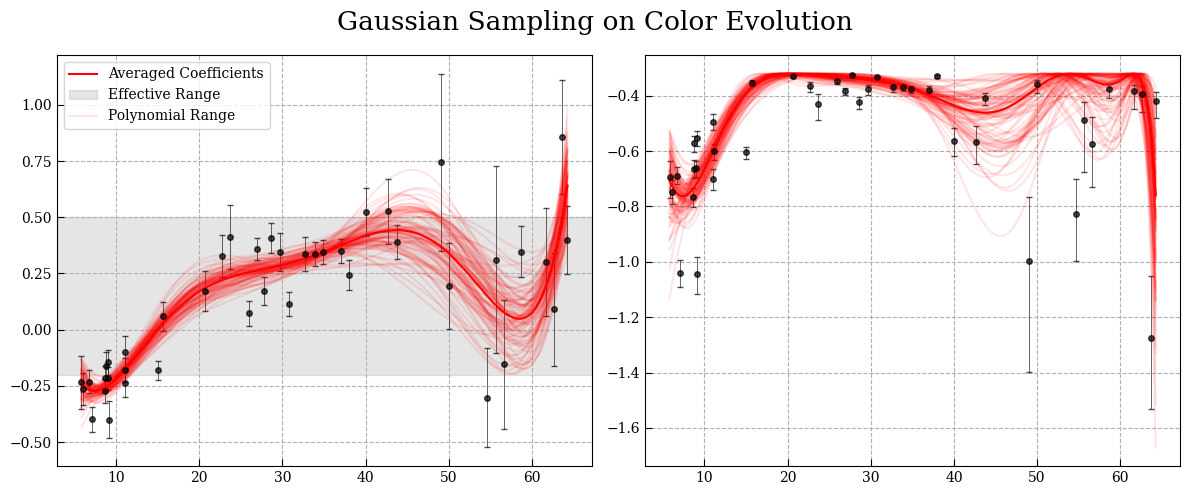

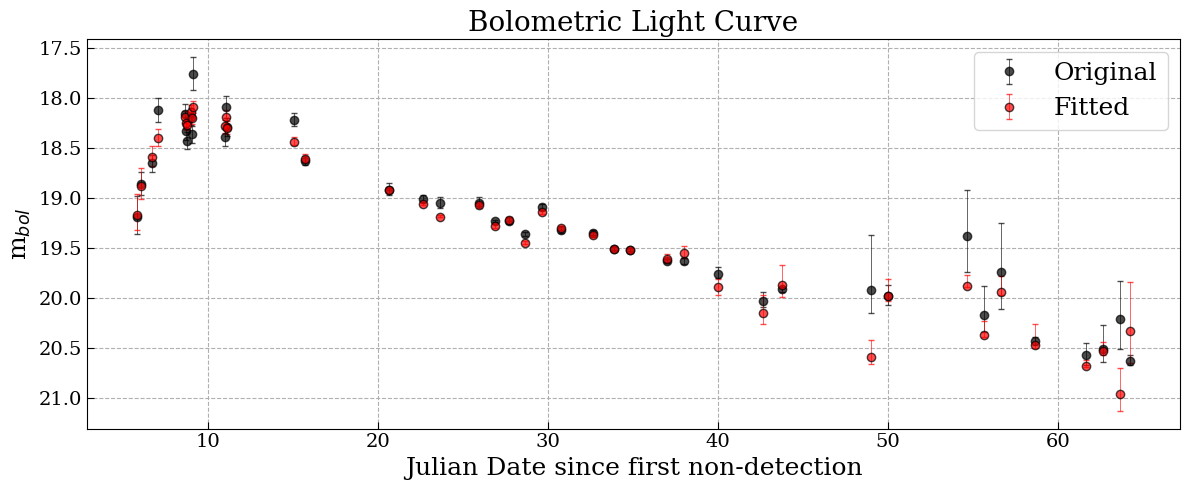

In [10]:
fig, (a0,a1) = plt.subplots(figsize=(12,5),ncols=2)
fig.suptitle("Gaussian Sampling on Color Evolution",size=19)
a0.errorbar(dates,color,yerr=color_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a1.errorbar(dates,correction,yerr=correction_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a0.plot(c_domain,poly_6(c_domain,*color_mean_coeff),c='r',label="Averaged Coefficients")
a1.plot(c_domain,BC_pol(poly_6(c_domain,*color_mean_coeff),BC_df.loc[0]['C0'],\
                                        BC_df.loc[0]['C1'],BC_df.loc[0]['C2']),c='r',label="Averaged Coefficients")

a0.axhspan(BC_df.loc[0]['Range'][0], BC_df.loc[0]['Range'][1] , alpha=0.2, color='gray',label="Effective Range")
for i,coeffs in enumerate(color_coeff):
    if i == 0:
        a0.plot(c_domain,poly_6(c_domain,*coeffs),alpha=0.1,label="Polynomial Range",c='r')
        a1.plot(c_domain,BC_pol(poly_6(c_domain,*coeffs),BC_df.loc[0]['C0'],\
                                        BC_df.loc[0]['C1'],BC_df.loc[0]['C2']),alpha=0.1,label="Polynomial Range",c='r')
    else:
        a0.plot(c_domain,poly_6(c_domain,*coeffs),alpha=0.1,c='r')
        a1.plot(c_domain,BC_pol(poly_6(c_domain,*coeffs),BC_df.loc[0]['C0'],\
                                        BC_df.loc[0]['C1'],BC_df.loc[0]['C2']),alpha=0.1,c='r')
        
a0.legend()
a0.grid(ls='--')
a1.grid(ls='--')

plt.tight_layout()

fig, a0 = plt.subplots(figsize=(12,5),ncols=1)
a0.errorbar(dates,mbol,yerr=mbol_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,label='Original')
a0.errorbar(dates,BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[0]['C0'],BC_df.loc[0]['C1'],BC_df.loc[0]['C2']) + Bmags,\
           yerr=simulated_err,fmt="ro",ecolor='r',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,mec='k',label='Fitted')
a0.invert_yaxis()
mbol_BV = BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[0]['C0'],BC_df.loc[0]['C1'],BC_df.loc[0]['C2']) + Bmags
a0.legend(prop={'size':18})
a0.grid(ls='--')
a0.set_title("Bolometric Light Curve",fontsize=20)
a0.set_xlabel(f"Julian Date since first non-detection",fontsize=18)
a0.set_ylabel(r"m$_{bol}$",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [11]:
# Save corrected bolometric magntiudes and new error bars
BVm = BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[0]['C0'],BC_df.loc[0]['C1'],BC_df.loc[0]['C2']) + Bmags
BVm_err = simulated_err

np.savez("Bolometric_LC_BV.npz",mag=BVm,err=BVm_err)

<h1 align='center'> Layman et al. 2016 B-i <h1>

In [12]:
# Collect specific rows numpy file
dates = data2['t']
mbol = data2['m']
mbol_err = data2['merr']
color = data2['c']
color_err = data2['cerr']
correction = data2['cor']
correction_err = data2['corerr']

In [13]:
# Run color smoothing algorithm
color_mean_coeff, color_coeff = HO_PolyFit(dates,color,color_err,100,6)
# Define color domain
c_domain = np.linspace(np.min(dates),np.max(dates),1000)

# Compute the uncertainty in the bolometric magnitudes through the sampling
# Compute the magnitudes in the corresponding dates
mbol_Uerr = []
mbol_Lerr = []
for i,date in enumerate(dates):
    sample = []
    for coeff in color_coeff:
        # Compute bolometric mag in same date for all coeff
        i_mbol = BC_pol(poly_6(date,*coeff),BC_df.loc[1]['C0'],\
                       BC_df.loc[1]['C1'],BC_df.loc[1]['C2']) + Bmags[i]
        sample.append(i_mbol)
    mbol_Uerr.append(np.percentile(sample,95)-np.median(sample))
    mbol_Lerr.append(np.median(sample)-np.percentile(sample,5))
simulated_err = [mbol_Lerr,mbol_Uerr]

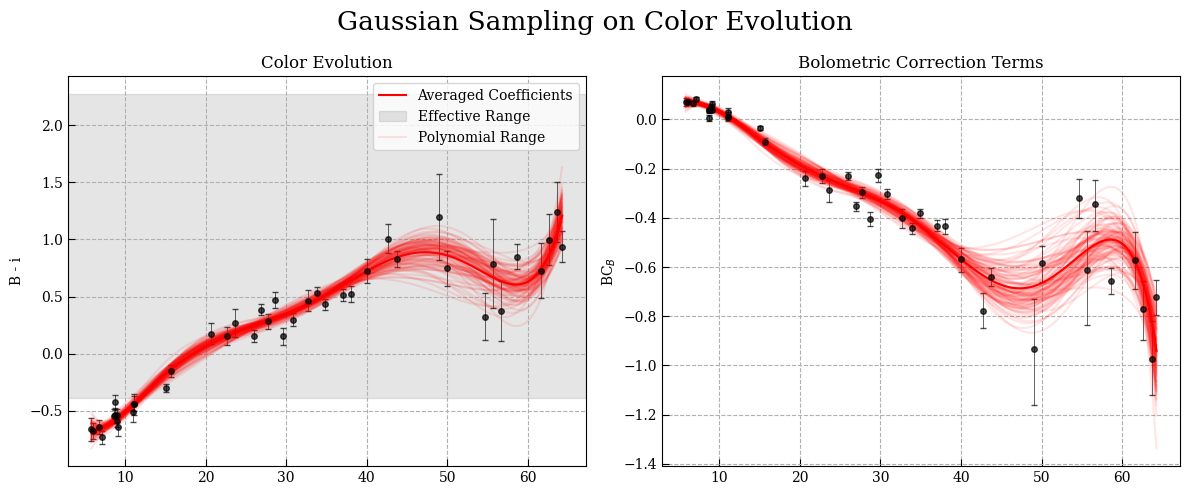

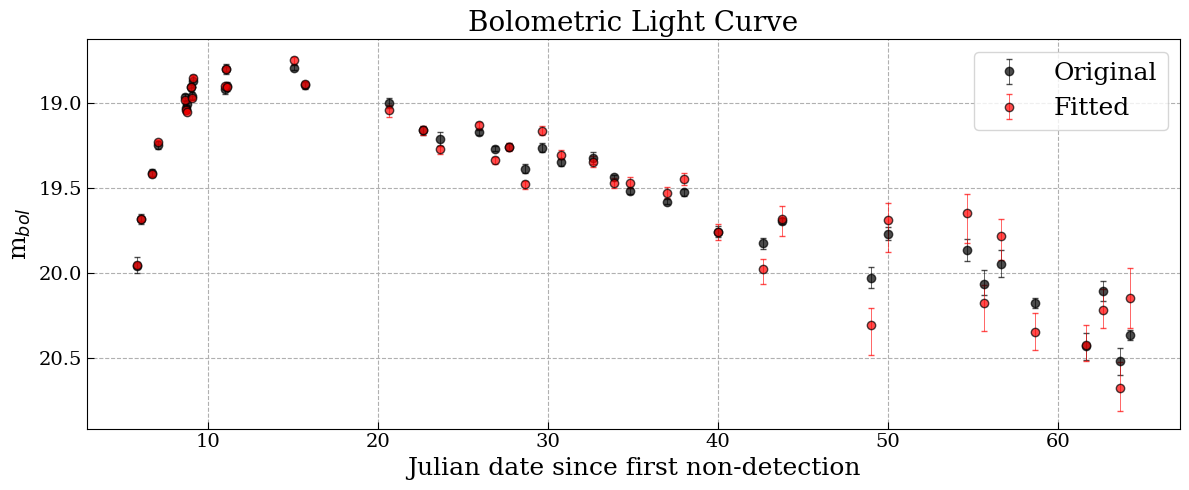

In [14]:
fig, (a0,a1) = plt.subplots(figsize=(12,5),ncols=2)
fig.suptitle("Gaussian Sampling on Color Evolution",size=19)
a0.errorbar(dates,color,yerr=color_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a1.errorbar(dates,correction,yerr=correction_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a0.plot(c_domain,poly_6(c_domain,*color_mean_coeff),c='r',label="Averaged Coefficients")
a1.plot(c_domain,BC_pol(poly_6(c_domain,*color_mean_coeff),BC_df.loc[1]['C0'],\
                                        BC_df.loc[1]['C1'],BC_df.loc[1]['C2']),c='r',label="Averaged Coefficients")
a0.set_title("Color Evolution")
a0.set_ylabel("B - i")
a1.set_title("Bolometric Correction Terms")
a1.set_ylabel("BC$_B$")

a0.axhspan(BC_df.loc[1]['Range'][0], BC_df.loc[1]['Range'][1] , alpha=0.2, color='gray',label="Effective Range")
for i,coeffs in enumerate(color_coeff):
    if i == 0:
        a0.plot(c_domain,poly_6(c_domain,*coeffs),alpha=0.1,label="Polynomial Range",c='r')
        a1.plot(c_domain,BC_pol(poly_6(c_domain,*coeffs),BC_df.loc[1]['C0'],\
                                        BC_df.loc[1]['C1'],BC_df.loc[1]['C2']),alpha=0.1,label="Polynomial Range",c='r')
    else:
        a0.plot(c_domain,poly_6(c_domain,*coeffs),alpha=0.1,c='r')
        a1.plot(c_domain,BC_pol(poly_6(c_domain,*coeffs),BC_df.loc[1]['C0'],\
                                        BC_df.loc[1]['C1'],BC_df.loc[1]['C2']),alpha=0.1,c='r')
        
a0.legend()
a0.grid(ls='--')
a1.grid(ls='--')

plt.tight_layout()

fig, a0 = plt.subplots(figsize=(12,5),ncols=1)
a0.errorbar(dates,mbol,yerr=mbol_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,label='Original')
a0.errorbar(dates,BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[1]['C0'],BC_df.loc[1]['C1'],BC_df.loc[1]['C2']) + Bmags,\
           yerr=simulated_err,fmt="ro",ecolor='r',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,mec='k',label='Fitted')
a0.invert_yaxis()
mbol_Bi = BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[1]['C0'],BC_df.loc[1]['C1'],BC_df.loc[1]['C2']) + Bmags
a0.legend(prop={'size':18})
a0.grid(ls='--')
a0.set_title("Bolometric Light Curve",fontsize=20)
a0.set_xlabel(f"Julian date since first non-detection",fontsize=18)
a0.set_ylabel(r"m$_{bol}$",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [15]:
Bim = BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[1]['C0'],BC_df.loc[1]['C1'],BC_df.loc[1]['C2']) + Bmags
Bim_err = simulated_err

<h1 align='center'>Layman et al. 2016 V-i <h1>

In [16]:
# Collect specific rows numpy file
dates = data3['t']
mbol = data3['m']
mbol_err = data3['merr']
color = data3['c']
color_err = data3['cerr']
correction = data3['cor']
correction_err = data3['corerr']

In [17]:
# Run color smoothing algorithm
color_mean_coeff, color_coeff = HO_PolyFit(dates,color,color_err,100,6)
# Define color domain
c_domain = np.linspace(np.min(dates),np.max(dates),1000)

# Compute the uncertainty in the bolometric magnitudes through the sampling
# Compute the magnitudes in the corresponding dates
mbol_Uerr = []
mbol_Lerr = []
for i,date in enumerate(dates):
    sample = []
    for coeff in color_coeff:
        # Compute bolometric mag in same date for all coeff
        i_mbol = BC_pol(poly_6(date,*coeff),BC_df.loc[2]['C0'],\
                       BC_df.loc[2]['C1'],BC_df.loc[2]['C2']) + Vmags[i]
        sample.append(i_mbol)
    mbol_Uerr.append(np.percentile(sample,95)-np.median(sample))
    mbol_Lerr.append(np.median(sample)-np.percentile(sample,5))
simulated_err = [mbol_Lerr,mbol_Uerr]

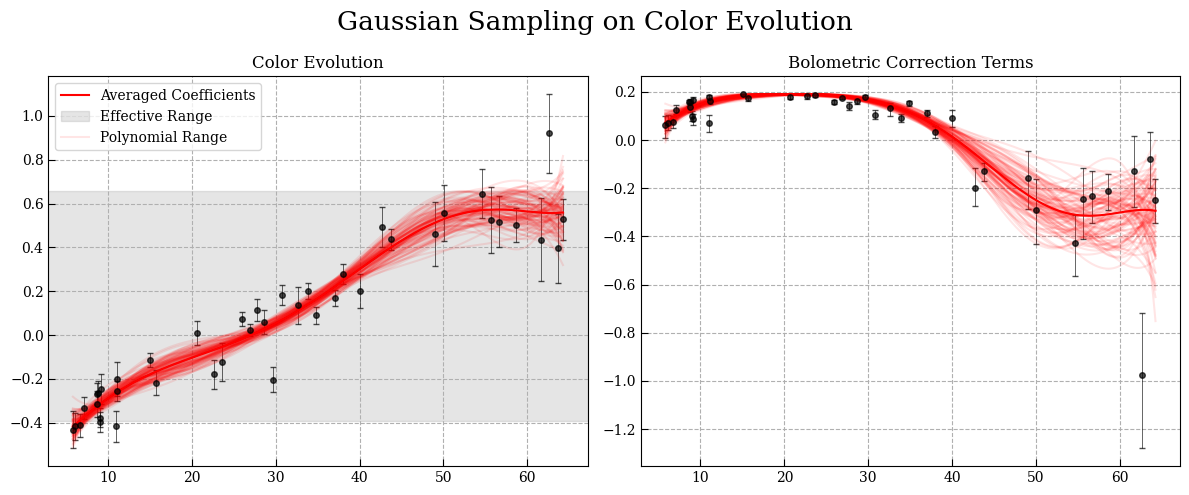

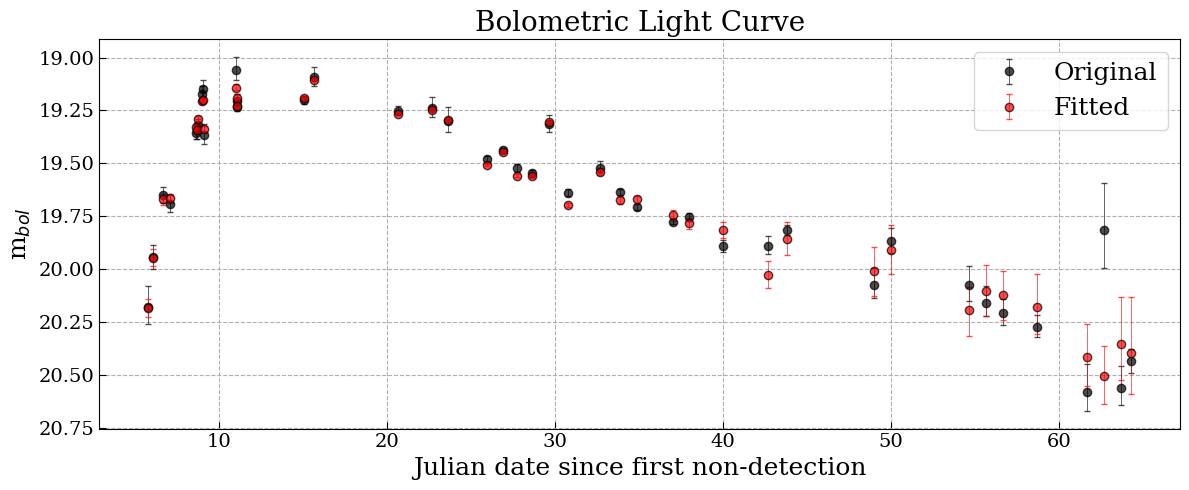

In [18]:
fig, (a0,a1) = plt.subplots(figsize=(12,5),ncols=2)
fig.suptitle("Gaussian Sampling on Color Evolution",size=19)
a0.errorbar(dates,color,yerr=color_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a1.errorbar(dates,correction,yerr=correction_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a0.plot(c_domain,poly_6(c_domain,*color_mean_coeff),c='r',label="Averaged Coefficients")
a1.plot(c_domain,BC_pol(poly_6(c_domain,*color_mean_coeff),BC_df.loc[2]['C0'],\
                                        BC_df.loc[2]['C1'],BC_df.loc[2]['C2']),c='r',label="Averaged Coefficients")
a0.set_title("Color Evolution")
a1.set_title("Bolometric Correction Terms")

a0.axhspan(BC_df.loc[2]['Range'][0], BC_df.loc[2]['Range'][1] , alpha=0.2, color='gray',label="Effective Range")
for i,coeffs in enumerate(color_coeff):
    if i == 0:
        a0.plot(c_domain,poly_6(c_domain,*coeffs),alpha=0.1,label="Polynomial Range",c='r')
        a1.plot(c_domain,BC_pol(poly_6(c_domain,*coeffs),BC_df.loc[2]['C0'],\
                                        BC_df.loc[2]['C1'],BC_df.loc[2]['C2']),alpha=0.1,label="Polynomial Range",c='r')
    else:
        a0.plot(c_domain,poly_6(c_domain,*coeffs),alpha=0.1,c='r')
        a1.plot(c_domain,BC_pol(poly_6(c_domain,*coeffs),BC_df.loc[2]['C0'],\
                                        BC_df.loc[2]['C1'],BC_df.loc[2]['C2']),alpha=0.1,c='r')
        
a0.legend()
a0.grid(ls='--')
a1.grid(ls='--')

plt.tight_layout()

fig, a0 = plt.subplots(figsize=(12,5),ncols=1)
a0.errorbar(dates,mbol,yerr=mbol_err,fmt="ko",ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,label='Original')
a0.errorbar(dates,BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[2]['C0'],BC_df.loc[2]['C1'],BC_df.loc[2]['C2']) + Vmags,\
           yerr=simulated_err,fmt="ro",ecolor='r',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,mec='k',label='Fitted')
a0.invert_yaxis()
mbol_Vi = BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[2]['C0'],BC_df.loc[2]['C1'],BC_df.loc[2]['C2']) + Vmags
a0.legend(prop={'size':18})
a0.grid(ls='--')
a0.set_title("Bolometric Light Curve",fontsize=20)
a0.set_xlabel(f"Julian date since first non-detection",fontsize=18)
a0.set_ylabel(r"m$_{bol}$",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [19]:
Vim = BC_pol(poly_6(dates,*color_mean_coeff),BC_df.loc[2]['C0'],BC_df.loc[2]['C1'],BC_df.loc[2]['C2']) + Vmags
Vim_err = simulated_err 

<h1 align='center'>Converting to bolometric luminosity using $z=0.1$<h1>

We need to find the comoving distance to the SN which can be found through the following expression

$$
    D_c = \frac{c}{H_0} \int_0^z \frac{dz'}{\sqrt{\Omega_{M,0}(1+z')^3 + \Omega_{k,0}(1+z')^2 + \Omega_{\Lambda,0}}}
$$

Where the current day accepeted cosmological parameters are

$$
\Omega_{M,0} =  0.27 \\
\Omega_{k,0} = 0.00 \\
\Omega_{\Lambda,0} =  0.73\\
H_0 = 73.24 \, \mathrm{(km \, s^{-1})\, Mpc^{-1}}
$$

Values for $H_0$, $\Omega_{M,0}$ and $\Omega_{\Lambda,0}$ are obtained from Reiss et al. $\href{https://iopscience.iop.org/article/10.3847/0004-637X/826/1/56}{2016}$. While $\Omega_{k,0}$ is calculated through its definition $\Omega_{M,0} + \Omega_{k,0} + \Omega_{\Lambda,0} = 1$ according to Hogg $\href{https://arxiv.org/pdf/astro-ph/9905116v4.pdf}{2020}$

Once we have comoving distance we can compute the luminosity distance as follows

$$
D_L = D_c(1+z)
$$

In [1]:
import numpy as np
# Define redshift
#z = 0.08739904944703399
z = 0.08918

# Define cosmological density parameters
OM = 0.27
OK = 0.00
OL = 0.73

In [2]:
import scipy.integrate as integrate
import astropy.units as u
from astropy.constants import c

# Numerically integrate for the comoving distance at z=0.1
def func(z,M,K,L):
    return(1/np.sqrt(M*(1+z)**3 + K*(1+z)**2 + L))

val = integrate.quad(func,0,z,args=(OM,OK,OL))


H = (74.2*u.km/u.s/u.Mpc).to(1/u.s) # 1/s
DC = c/H *val
DL = DC*(1+z)
Dl, Dl_err = DL[0], DL[1]
print("Distance to ZN-7090")
print(Dl.to(u.Mpc),"(+/-)",Dl_err.to(u.Mpc))

c:\Users\patri\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Distance to ZN-7090
385.21041402590015 Mpc (+/-) 4.276694709769436e-12 Mpc


## Compute absolute bolometric magnitude for each correction using the calculated value for $D_{L}$ using the following expression

$$
M = m - 5\mathrm{log}_{10}\left(\frac{D_L}{10\, \mathrm{pc}}\right)
$$

From absolute magnitude we can compute the luminosity throug the following relationship 

$$
\frac{L_{bol,*}}{L_{bol,\odot}} = 100^{(M_{bol,\odot} - M_{bol,*})/5}
$$

Where 

$$
L_{bol,\odot} = 3.845 \times 10^{33}\, \mathrm{erg s^{-1}}\\
M_{bol,\odot} = 4.74 
$$

In [33]:
# Convert from apparent bolometric magntiudes to absolute bolometric magnitudes
BVM = BVm - 5*np.log10(Dl.to(u.pc)/(10*u.pc))
BiM = Bim - 5*np.log10(Dl.to(u.pc)/(10*u.pc))
ViM = Vim - 5*np.log10(Dl.to(u.pc)/(10*u.pc))

# Convert from bolometric absolute magnitude to bolometric luminosity
Lsun = 3.845e33 *u.erg/u.s
Msun = 4.74

# Use the bolometric luminosity calculated through the color evoluion fit
BVL = (Lsun*100**((Msun - BVM)/5)).value
BiL = (Lsun*100**((Msun - BiM)/5)).value
ViL = (Lsun*100**((Msun - ViM)/5)).value

<Quantity 1.16343766e+25 m>

In [23]:
from Bolometric_Corrections import Layman2Luminosity

Lbol1, Lbol_err1 = Layman2Luminosity(Bmags,Vmags,Bmags_err,Vmags_err,BC_df.loc[0]['C0'],\
                                     BC_df.loc[0]['C1'],BC_df.loc[0]['C2'],z,[-0.2, 0.5],"A")

Lbol2, Lbol_err2 = Layman2Luminosity(Bmags,imags,Bmags_err,imags_err,BC_df.loc[1]['C0'],\
                                     BC_df.loc[1]['C1'],BC_df.loc[1]['C2'],z,[-0.392, 2.273],"S")

Lbol3, Lbol_err3 = Layman2Luminosity(Vmags,imags,Vmags_err,imags_err,BC_df.loc[2]['C0'],\
                                     BC_df.loc[2]['C1'],BC_df.loc[2]['C2'],z,[-0.391, 0.658],"S")

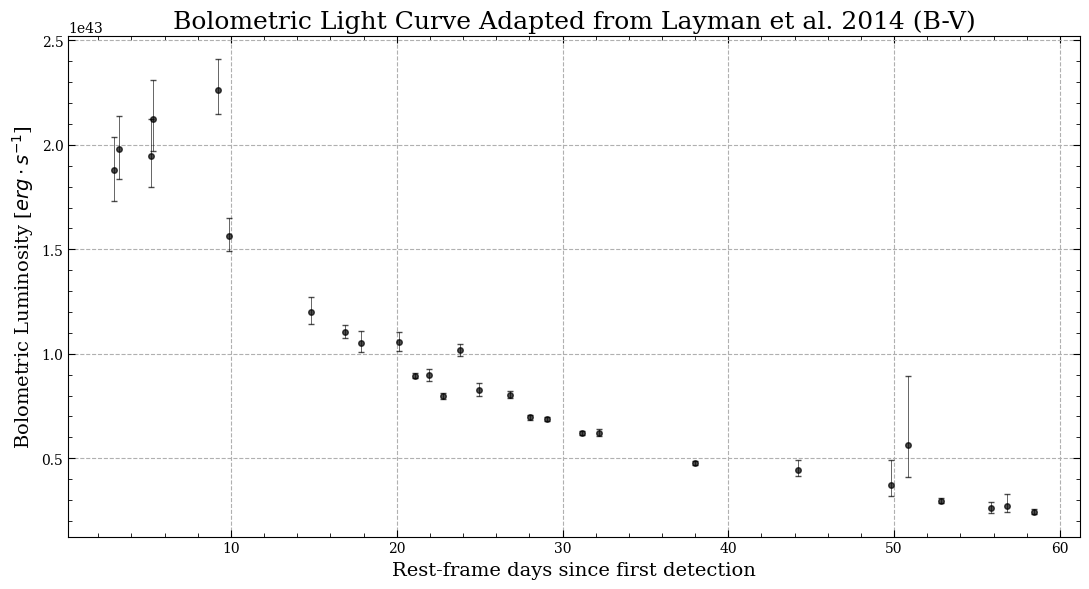

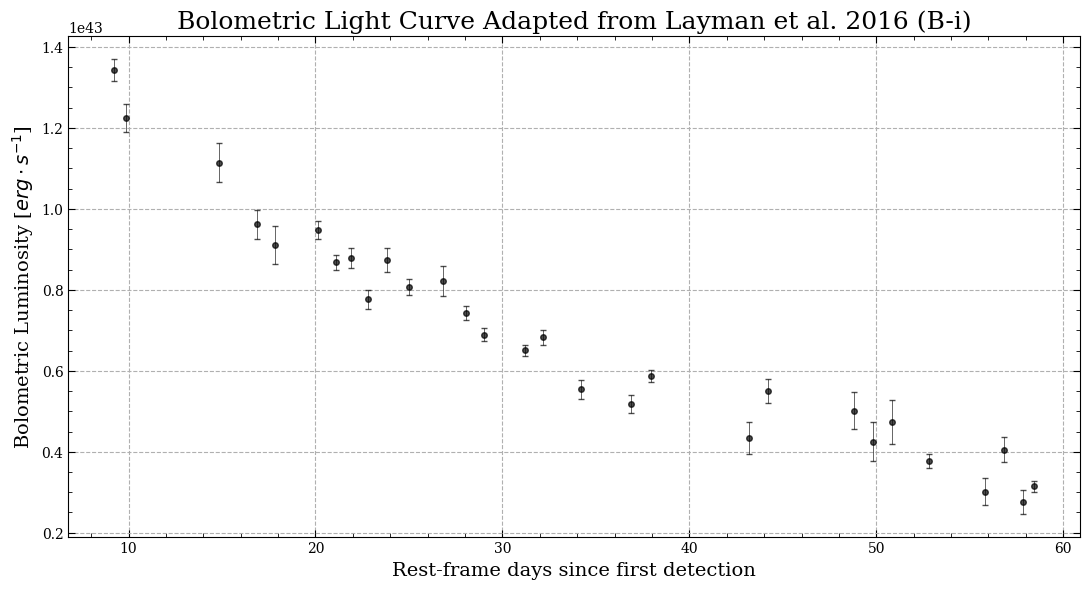

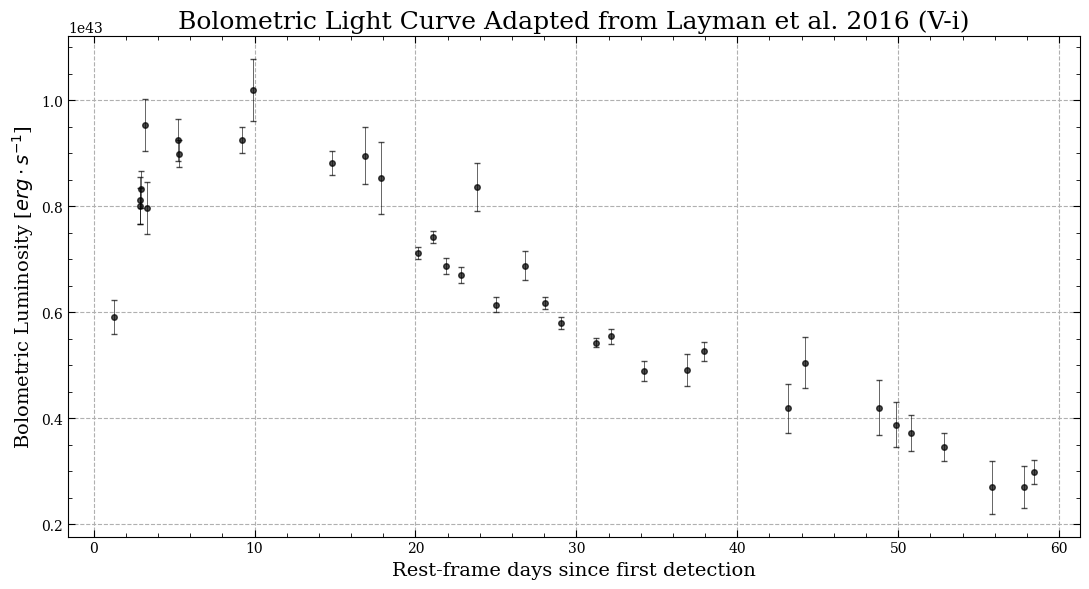

In [36]:
fig, a0 = plt.subplots(figsize=(11,6),ncols=1)
dates_p = dates - dates[0]
dates_pBV = dates_p[np.where(np.logical_and(Bmags-Vmags>=-0.2,Bmags - Vmags <= 0.5))]
dates_pBi = dates_p[np.where(np.logical_and(Bmags-imags>=-0.392,Bmags - imags <= 2.273))]
dates_pVi = dates_p[np.where(np.logical_and(Vmags-imags>=-0.391,Vmags - imags <= 0.658))]

a0.errorbar(dates_pBV,Lbol1,yerr=Lbol_err1,fmt='ko',ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a0.set_xlabel(f"Rest-frame days since first detection",fontsize=14)
a0.set_ylabel(r"Bolometric Luminosity [$erg \cdot s^{-1}$]",fontsize=14)
a0.set_title("Bolometric Light Curve Adapted from Layman et al. 2014 (B-V)",fontsize=18)
a0.grid(ls='--')
a0.yaxis.set_minor_locator(MultipleLocator(0.1e43))
a0.xaxis.set_minor_locator(MultipleLocator(2))
a0.yaxis.set_ticks_position('both')
a0.xaxis.set_ticks_position('both')
plt.tight_layout()
plt.show()

fig, a0 = plt.subplots(figsize=(11,6),ncols=1)
a0.errorbar(dates_pBi,Lbol2,yerr=Lbol_err2,fmt='ko',ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a0.set_xlabel(f"Rest-frame days since first detection",fontsize=14)
a0.set_ylabel(r"Bolometric Luminosity [$erg \cdot s^{-1}$]",fontsize=14)
a0.set_title("Bolometric Light Curve Adapted from Layman et al. 2016 (B-i)",fontsize=18)
a0.grid(ls='--')
a0.yaxis.set_minor_locator(MultipleLocator(0.05e43))
a0.xaxis.set_minor_locator(MultipleLocator(2))
a0.yaxis.set_ticks_position('both')
a0.xaxis.set_ticks_position('both')
plt.tight_layout()
plt.show()

fig, a0 = plt.subplots(figsize=(11,6),ncols=1)
a0.errorbar(dates_pVi,Lbol3,yerr=Lbol_err3,fmt='ko',ecolor='k',capsize=2,elinewidth=0.6,alpha=0.7,ms=4)
a0.set_xlabel(f"Rest-frame days since first detection",fontsize=14)
a0.set_ylabel(r"Bolometric Luminosity [$erg \cdot s^{-1}$]",fontsize=14)
a0.set_title("Bolometric Light Curve Adapted from Layman et al. 2016 (V-i)",fontsize=18)
a0.grid(ls='--')
a0.yaxis.set_minor_locator(MultipleLocator(0.05e43))
a0.xaxis.set_minor_locator(MultipleLocator(2))
a0.yaxis.set_ticks_position('both')
a0.xaxis.set_ticks_position('both')
plt.tight_layout()
plt.savefig("Bolometric LC Final.png")
plt.show()

# Save light curves in npz file
np.savez("BVm_LC.npz",LC=Lbol1,LCerr=Lbol_err1,t=dates_pBV)
np.savez("Bim_LC.npz",LC=Lbol2,LCerr=Lbol_err2,t=dates_pBi)
np.savez("Vim_LC.npz",LC=Lbol3,LCerr=Lbol_err3,t=dates_pVi)


Bolometric correction for V-i provides the best color coverage, we see a good bolometric light curve, however, the literature specifies this correction to be derived from a SESN sample therefore, we cannot truly trust its results. The next best correction is the B-V correction as this one is derived from a general Type II SN sample.

<h1 align='center'> Observe distributions of MC Simulations <h2>

Lyman et al. 2014 (B-V)


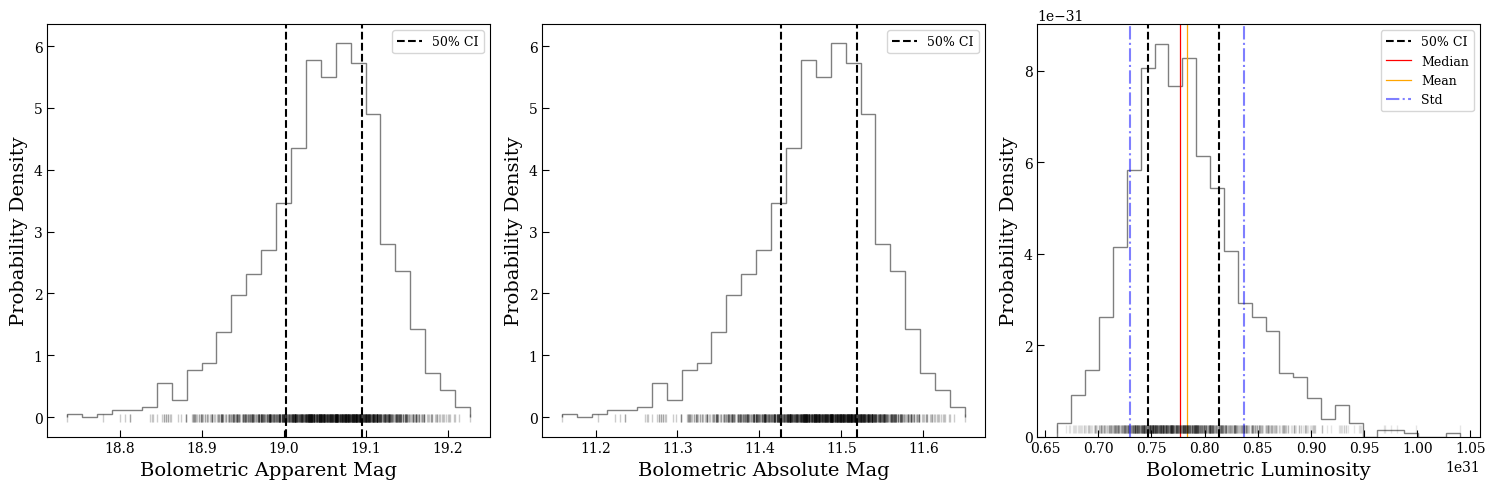

Pearson's Median Skewness of Bolometric Luminosity Distribution
0.3924035717062136
Lyman et al. 2016 (B-i)


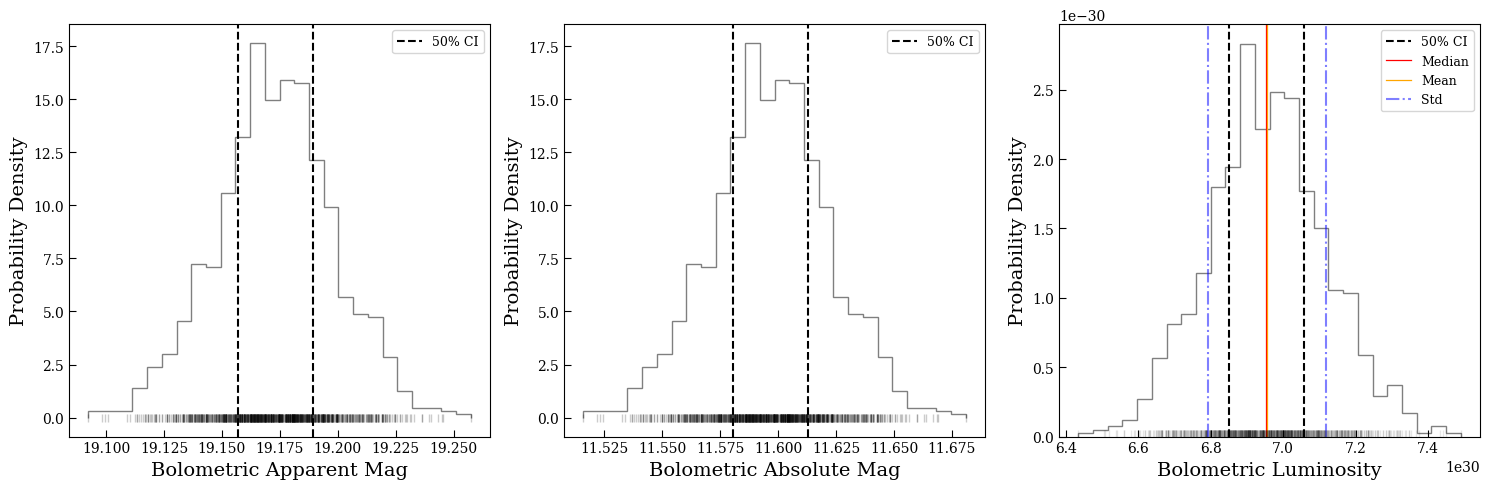

Pearson's Median Skewness of Bolometric Luminosity Distribution
0.055197593551982935
Lyman et al. 2016 (V-i)


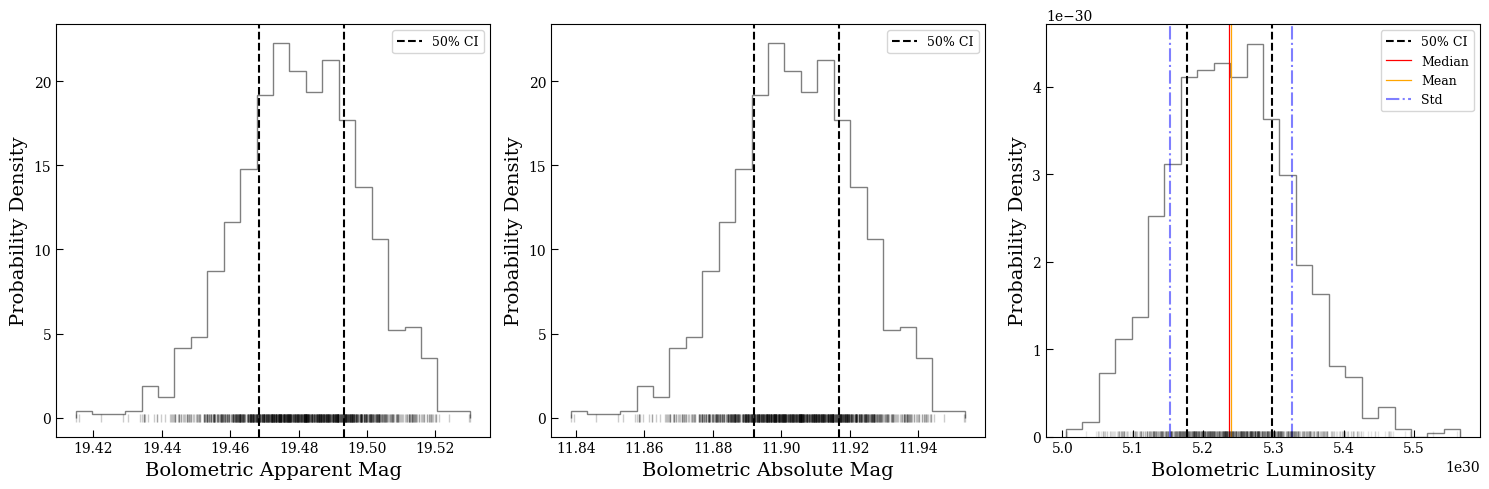

Pearson's Median Skewness of Bolometric Luminosity Distribution
0.09099154481712765


In [ ]:
from Helpers import MC_Simulation_Graph,MC_Simulation_Array
sample_i = 18
print("Lyman et al. 2014 (B-V)")
MC_Simulation_Graph(Bmags,Vmags,Bmags_err,Vmags_err,BC_df.loc[0]['C0'], BC_df.loc[0]['C1'], BC_df.loc[0]['C2'],(Dl.to(u.pc)).value,\
             sample_i)

print("Lyman et al. 2016 (B-i)")
MC_Simulation_Graph(Bmags,imags,Bmags_err,imags_err,BC_df.loc[1]['C0'], BC_df.loc[1]['C1'], BC_df.loc[1]['C2'],(Dl.to(u.pc)).value,\
             sample_i)
print("Lyman et al. 2016 (V-i)")
MC_Simulation_Graph(Vmags,imags,Vmags_err,imags_err,BC_df.loc[2]['C0'], BC_df.loc[2]['C1'], BC_df.loc[2]['C2'],(Dl.to(u.pc)).value,\
             sample_i)

Layman 2014 (B-V)


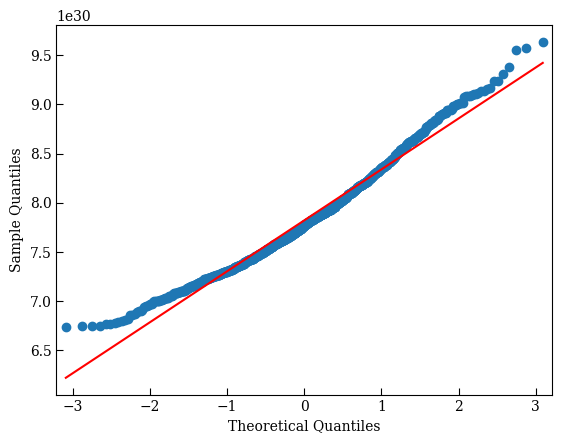

Layman 2016 (B-i)


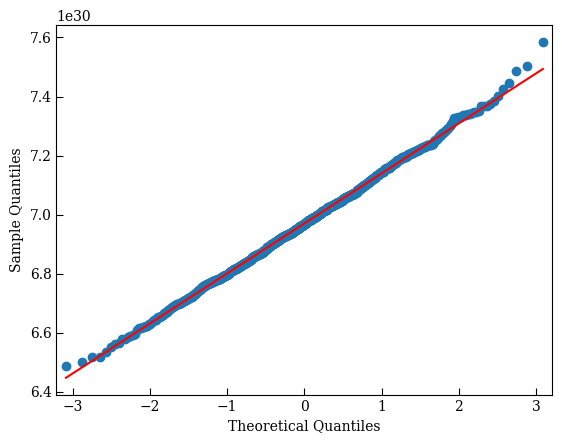

Layman 2016 (V-i)


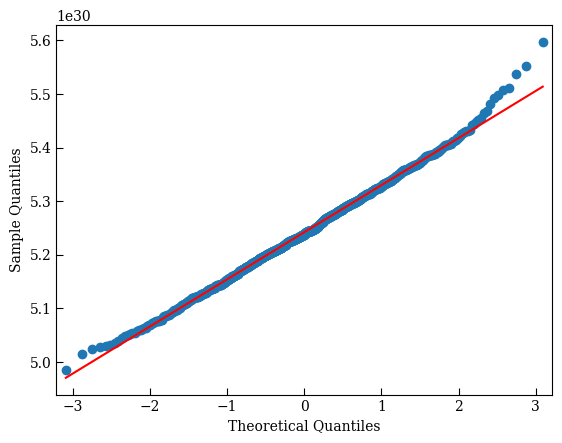

In [ ]:

s_BV = MC_Simulation_Array(Bmags,Vmags,Bmags_err,Vmags_err,BC_df.loc[0]['C0'], BC_df.loc[0]['C1'], BC_df.loc[0]['C2'],(Dl.to(u.pc)).value,\
             sample_i)[-1]
s_Bi = MC_Simulation_Array(Bmags,imags,Bmags_err,imags_err,BC_df.loc[1]['C0'], BC_df.loc[1]['C1'], BC_df.loc[1]['C2'],(Dl.to(u.pc)).value,\
             sample_i)[-1]
s_Vi = MC_Simulation_Array(Vmags,imags,Vmags_err,imags_err,BC_df.loc[2]['C0'], BC_df.loc[2]['C1'], BC_df.loc[2]['C2'],(Dl.to(u.pc)).value,\
             sample_i)[-1]
print("Layman 2014 (B-V)")
fig = sm.qqplot(s_BV,line='s')
plt.show()

print("Layman 2016 (B-i)")
fig = sm.qqplot(s_Bi,line='s')
plt.savefig("QQ Plot Lyman Bi.png")
plt.show()

print("Layman 2016 (V-i)")
fig = sm.qqplot(s_Vi,line='s')
plt.show()

From the QQ-Plots and the Pearson Median Skewness factor we conclude that we can safely treat the (B-i) and (V-i) bolometri luminosity distributions as Gaussian distributions.

<h2 align='center'>KSP ZN-7090 BVi Luminosity Light Curves<h2>

In [ ]:
def Mag2Luminosity(mag,mag_err,Dl):
    """
    Converts observed magntiudes to luminosities by applying the luminosity distance
    and the distance modulus equation. Dl needs to be in units of pc
    """
    import numpy as np
    
    # Initialize needed constants
    Lsun = 3.845e33 
    Msun = 4.74
    
    mtop = mag+mag_err
    
    # Convert to absolute magnitude
    M = mag - 5*np.log10(Dl/(10))
    Mtop = mtop - 5*np.log10(Dl/(10))
    # Convert to luminosity
    L = (Lsun*100**((Msun - M)/5))
    Ltop = (Lsun*100**((Msun - Mtop)/5))
    
    return(L,L-Ltop)
    

The mehtod below for computing the luminosity light curves for each band may not be correct, because the equations used are for bolometric magntiudes and not monochromatic magntiudes as I have used in this case. To correct this we need to look at how monochromatic magnitudes are defined

In practice monochromatic magnitudes are defined with respect to zero point spectral flux density which correspond to the indidual bands of the magntiude system and can either be in units of $\mathrm{erg/(cm^2 \cdot s \cdot Hz)}$ or $\mathrm{erg/(cm^2\cdot s\cdot cm)}$ which are known as spectral flux density per unit frequency and spectral flux density per unit wavelength.

$$
m_{\nu} = -2.5\mathrm{log}\left(\frac{f_{\nu}}{f_{\nu,0}}\right)\\
m_{\lambda} = -2.5\mathrm{log}\left(\frac{f_{\lambda}}{f_{\lambda,0}}\right)
$$

Where $f_{\lambda,0}$ is the zero point spectral flux density per unit wavelength. If we know $f_{\lambda,0}$ we can easily compute the spectral flux density of other monochromatic magntiudes

$$
f_{\lambda_{eff},x} = (f_{\lambda_{eff,x},0})(10^{-m_x/2.5})
$$

And if we dont know $f_{\lambda,0}$ but we do know $f_{\nu,0}$ then we can use the following coversion between both spectral flux densities and obtain the following result.

$$
f_{\lambda_{eff},x} = \left(\frac{c}{\lambda_{eff,x}^2}\right)\left(f_{\nu_{eff,x},0}\right)\left(10^{-m_x/2.5}\right)
$$

Where the zero point spectral flux densities and effective wavelenght for the bands of interest are given as follows

B-band: $f_{\nu_{eff},0} = 4063\, \mathrm{Jy}$ , $f_{\lambda_{eff},0} = 632 \times 10^{-11} \mathrm{erg/s/cm^2/A}$ , $\lambda_{eff} = 0.4361 \, \mathrm{\mu m}$

V-band: $f_{\nu_{eff},0} = 3636\, \mathrm{Jy}$ , $f_{\lambda_{eff},0} = 363.1 \times 10^{-11} \mathrm{erg/s/cm^2/A}$ , $\lambda_{eff} = 0.5448 \, \mathrm{\mu m}$

i-band: $f_{\nu_{eff},0} = 3631\, \mathrm{Jy}$ , $\lambda_{eff} = 0.7672 \, \mathrm{\mu m}$ 

In [ ]:
def FluxDensityAnal(mx,mx_err)

In [ ]:
def FluxDensity(mx,mx_err,wave,fwave0=None,fnu0=None):
    '''
    Computes the flux density per unit wavelength for
    specified apparent magntiude and effective wavelength
    Zero point flux density per unit wavelnegth or 
    zero point flux density per unit frequency is must 
    be provided for conversion.
    '''
    # Constants
    c = 2.99792458e10 #cm/s
    
    # Convert wavelenght from um to cm
    wave = wave*1e-4
    
    # Initialize arrays for flux densities
    fwave = []
    fwave_err = []
    
    # Check if flux density per unit wavelength is provided
    if fwave0 is not None:
        for i,m in enumerate(mx):
            ms = np.random.normal(loc=m,scale=mx_err[i],size=1000)
            fs = fwave0*np.power(10,(-ms/2.5))
            fwave.append(np.mean(fs))
            fwave_err.append(np.std(fs))
            
    elif fnu0 is not None:
        for i,m in enumerate(mx):
            ms = np.random.normal(loc=m,scale=mx_err[i],size=1000)
            fs = (c/wave**2)*fnu0*np.power(10,-ms/2.5)
            fwave.append(np.mean(fs))
            fwave_err.append(np.std(fs))
    else:
        print("Must provide a zero point flux density")
    
    return(fwave,fwave_err)

In [ ]:
# Define effective wavelengths and zeropoints flux densities
B_wave = 0.4361 #um
V_wave = 0.5448 #um
i_wave = 0.7672 #um

fwaveB = 632e-11 #erg/s/cm2/A
fnuB = 4063 # Jy
fwaveV = 363.1e-11 # erg/s/cm2/A
fnuV = 3636 # Jy
fnui = 3631*1e-23 # Jy -> erg/s/cm2/Hz

#fB, fB_err = np.array(FluxDensity(Bmags,Bmags_err,B_wave,fnu0=fnuB))
fB, fB_err = np.array(FluxDensity(Bmags,Bmags_err,B_wave,fwave0=fwaveB))*1e8 # erg/cm2/s/A -> erg/cm2/s/cm
#fV, fV_err = np.array(FluxDensity(Vmags,Vmags_err,V_wave,fnu0=fnuV))
fV, fV_err = np.array(FluxDensity(Vmags,Vmags_err,V_wave,fwave0=fwaveV))*1e8 # erg/cm2/s/A -> erg/cm2/s/cm
fi, fi_err = np.array(FluxDensity(imags,imags_err,i_wave,fnu0=fnui))

In [ ]:
from Helpers import Mag2Luminosity
dates_p = dates_p/(1+z)
dates = dates/(1+z)
#BL,BL_err = Mag2Luminosity(Bmags,Bmags_err,(Dl.to(u.pc)).value)
#VL,VL_err = Mag2Luminosity(Vmags,Vmags_err,(Dl.to(u.pc)).value)
#iL,iL_err = Mag2Luminosity(imags,imags_err,(Dl.to(u.pc)).value)

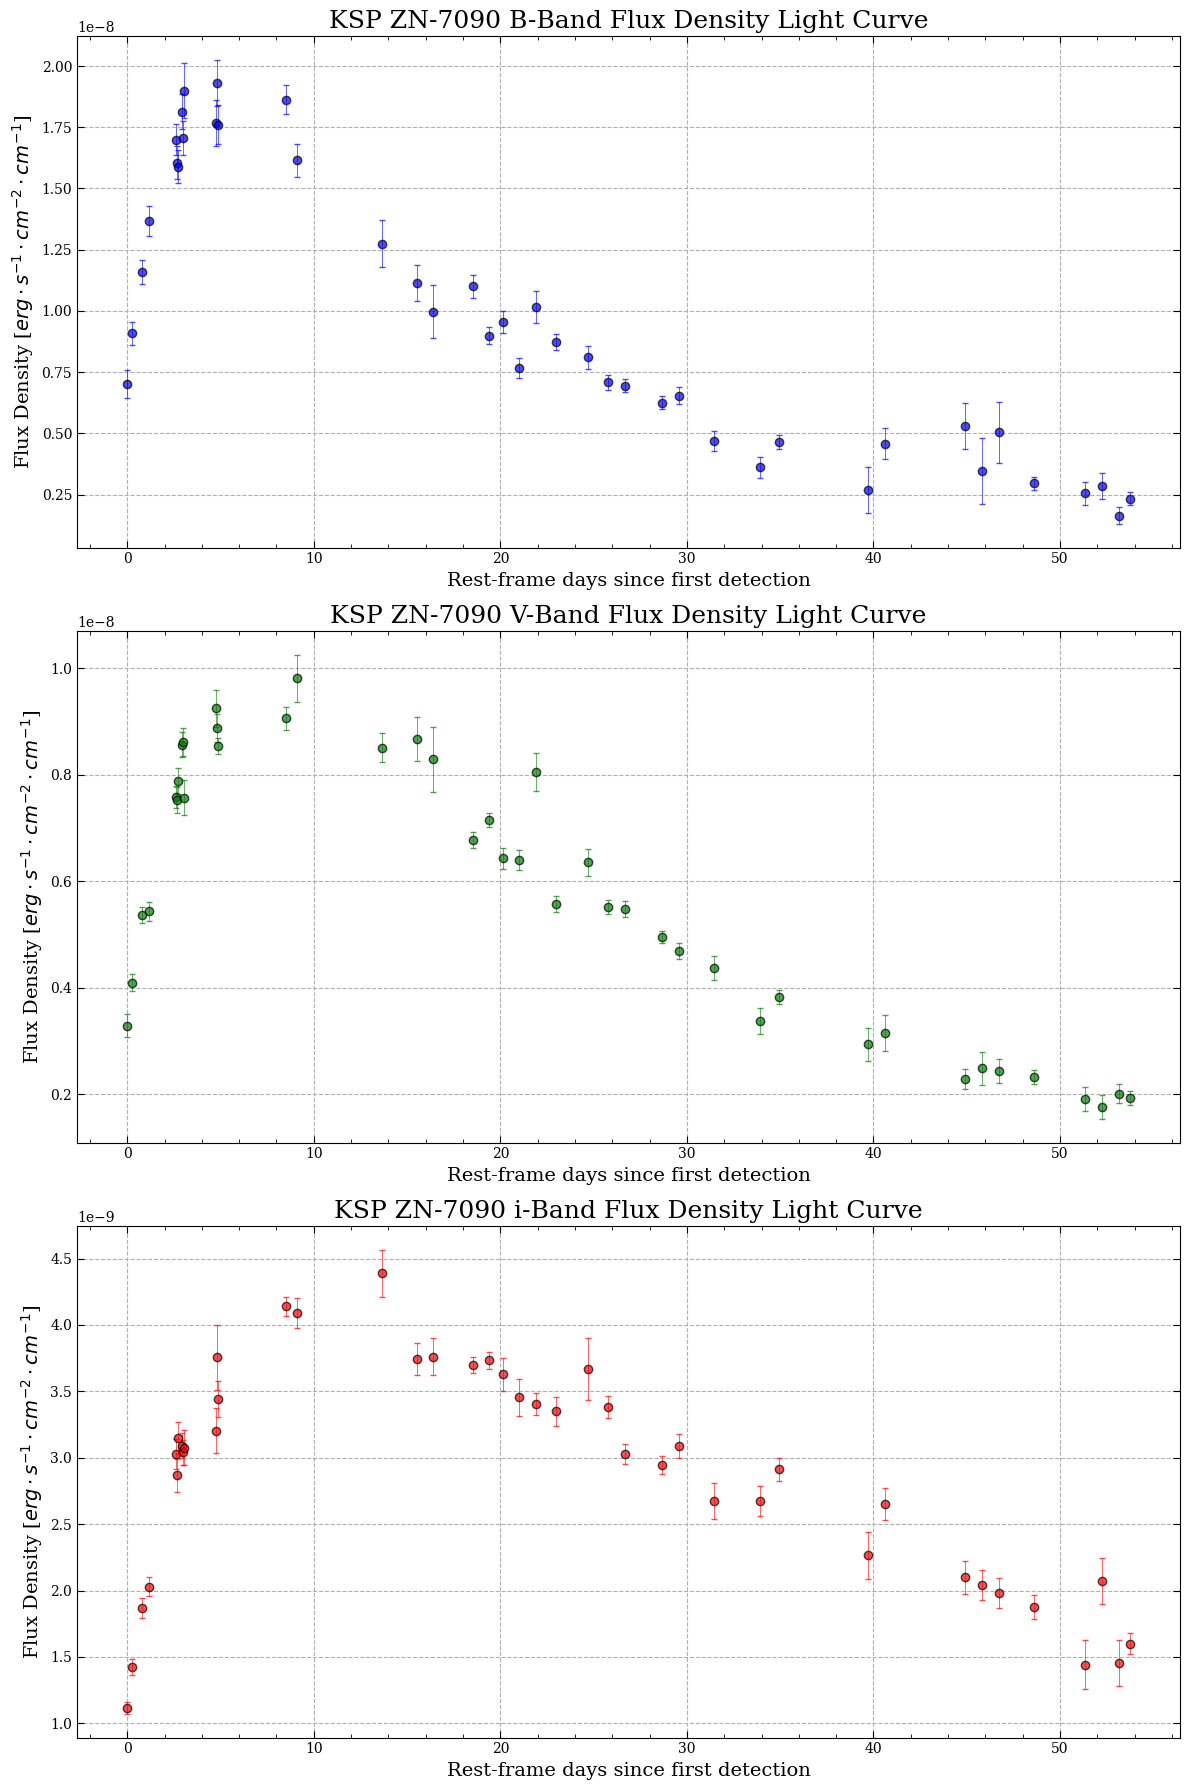

In [ ]:
fig,(a0,a1,a2) = plt.subplots(figsize=(12,18),nrows=3)
a0.errorbar(dates_p,fB,yerr=fB_err,fmt='bo',ecolor='b',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,mec='k')
a0.set_title("KSP ZN-7090 B-Band Flux Density Light Curve",fontsize=18)
a0.set_ylabel("Flux Density [$erg \cdot s^{-1}\cdot cm^{-2} \cdot cm^{-1}$]",fontsize=14)
a0.set_xlabel("Rest-frame days since first detection",fontsize=14)
a0.grid(ls='--')
a0.yaxis.set_minor_locator(MultipleLocator(0.05e15))
a0.xaxis.set_minor_locator(MultipleLocator(2))
a0.yaxis.set_ticks_position('both')
a0.xaxis.set_ticks_position('both')

a1.errorbar(dates_p,fV,yerr=fV_err,fmt='go',ecolor='g',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,mec='k')
a1.set_title("KSP ZN-7090 V-Band Flux Density Light Curve",fontsize=18)
a1.set_ylabel("Flux Density [$erg \cdot s^{-1}\cdot cm^{-2} \cdot cm^{-1}$]",fontsize=14)
a1.set_xlabel("Rest-frame days since first detection",fontsize=14)
a1.grid(ls='--')
a1.yaxis.set_minor_locator(MultipleLocator(0.05e15))
a1.xaxis.set_minor_locator(MultipleLocator(2))
a1.yaxis.set_ticks_position('both')
a1.xaxis.set_ticks_position('both')

a2.errorbar(dates_p,fi,yerr=fi_err,fmt='ro',ecolor='r',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,mec='k')
a2.set_title("KSP ZN-7090 i-Band Flux Density Light Curve",fontsize=18)
a2.set_ylabel("Flux Density [$erg \cdot s^{-1}\cdot cm^{-2} \cdot cm^{-1}$]",fontsize=14)
a2.set_xlabel("Rest-frame days since first detection",fontsize=14)
a2.grid(ls='--')
a2.yaxis.set_minor_locator(MultipleLocator(0.05e14))
a2.xaxis.set_minor_locator(MultipleLocator(2))
a2.yaxis.set_ticks_position('both')
a2.xaxis.set_ticks_position('both')

plt.tight_layout()
plt.show()

Effective wavelength for Vega Johnson-Cousins

B: $\lambda_{eff} = 0.4361 \, \mathrm{\mu m}$

V: $\lambda_{eff} = 0.5448 \, \mathrm{\mu m}$

Effective wavelength for AB, Sloan

i: $\lambda_{eff} = 0.7672 \, \mathrm{\mu m}$

## Rabinak & Waxman 2011

Implementing simple model for a Hydrogen rich envelope star (RSG) and fitting for physical parameters. We take the bolometric solution corresponding for a polytropic index of $n=3/2$ of the following form.

$$
    L(t) = 8.5 \times 10^{42} \, \frac{E_{51}^{0.92}R_{*,13}}{f_{\rho}^{0.27}(M/M_{\odot})^{0.84}\kappa_{0.34}^{0.92}}t_5^{-0.16} \, \mathrm{erg \, s^{-1}}
$$

Notice that this is a strictly monotonic function which does not seem to fit the early rise of the light curve. The explanation here is that if we consider the luminosity of a single band then this luminosity is equal to the bolometric luminosity times the blackbody integrated over the bandpass of the band. Because the SN is cooling the peak of the blackbody will shift to longer wavelengths and which results in the rise and fall of the luminosity light curve. Here we outline the spectral luminosity per wavelength (erg/s/cm)

$$
L_{\lambda}(t) = L(t) \times \frac{T_{col}(t)}{hc}\times g_{BB}\left(\frac{hc}{\lambda T_{col}(t)}\right)
$$

Where at early times 

$$
T_{col} = 1.1 \times T_{ph}(t)
$$

$$
T_{ph} = 1.6 f_{\rho}^{-0.037}\frac{E^{0.027}_{51} R^{1/4}_{*,13}}{(M/M_{\odot})^{0.054}\kappa_{0.34}^{0.28}}t_5^{-0.45}\, \mathrm{eV}
$$

And 

$$
    g_{BB}(x) = \frac{15x^5}{\pi^4(\mathrm{exp}(x)-1)}
$$

Is the normalized plank function

According to Rabinak 2011 at early times the dominant source of opacity in a Type II SNe is Thompson scattering, due to the high ionization of the envelope. However, the specific value for this quantity depends on the He mass fraction

$$
\kappa_{es} = 0.2(1+X)\, \mathrm{cm^2\, g^{-1}}
$$

Therefore I will be fitting the for $\kappa$ because I am not sure what to use for the He mass fraction

Additionally, $f_{\rho}$ is a dimensionless quantity that quantifies the density of the ejecta. Calzavara & Matzner have derived the expected values for $f_{\rho}$ for various progenitors from $0.031 < f_{\rho} < 0.062$ for BSG and $0.079 < f_{\rho} < 0.13$ for RSG. Rabinak and Waxman note that their results are not sensitive to the specific values of $f_{\rho}$.

Read literature on values for $\kappa$ and fix it as a constant

The paper states its models describes the evolution of Type II SNe on a range of hour to days from the first elecrtromagnetic emission. However, it does not specify an specific date range to which the model works best for. However they do mention that the focus of their paper is to study the $\sim$ 1 day UV/O emssion following the X-ray burst. So noting this I am thinking of fitting the data post 2 days from the first detection

<h2 align='center'>Analytical Model Fit Interval<h2>

In SW 2017 they state that  their model should only be used for $T > 0.7\, \mathrm{eV}$, we know the distance to ZN 7090 so assuming an black body we can estimate what is the corresponding luminosity for such temperature.

$$
L = F \, 4 \pi D_L^2\\
L = \sigma T^4 4\pi D_L^2
$$

## Nir Sapir & Waxman 2017

This paper provides an extension for the 2011 model for later times by adding a suppression factor to the luminosity function as follows

$$
\frac{L}{L_{RW}} = A\mathrm{exp}\left[-\left(\frac{at}{t_{tr}}\right)^\alpha\right]
$$

Where $A=0.94$, $a=1.67$, $\alpha=0.8$ for convection efficient envelopes ($n=3/2$)

So I will use the early luminosity model to fit the first 2 days of the light curve and then use the supression factor to fit the rest of the light curve. We can then use the fitting parameters to corroborate the values of physical parameters

In [ ]:
from Helpers import BBflux, RabinakShockCooling

In [ ]:
def ShockCoolingModel(t_day,E51,R13,M,k34,fp):
    """
    Model function for flux density per unit wavelenght given
    analytical Temp and L from Rabinak & Waxman.
    """
    # Constants
    c = 2.99792458e10 #cm/s
    kB = 8.617333262e-5 #eV/K
    
    # Scale time
    t = t_day * 86400 #s
    t5 = t/1e5
    
    # Slice length
    N = int(len(t_day)/3)
    
    # Slice domains for 3 bands
    t5B, t5V, t5i = t5[:N], t5[:N], t5[:N]
    
    # Use analytical models to compute L and T
    LB,TphB = RabinakShockCooling(t5B,E51,R13,M,k34,fp)
    LV,TphV = RabinakShockCooling(t5V,E51,R13,M,k34,fp)
    Li,Tphi = RabinakShockCooling(t5i,E51,R13,M,k34,fp)
    
    # Convert Tph eV -> K
    TphB = TphB/kB
    TphV = TphV/kB
    Tphi = Tphi/kB
    
    Bwave = 0.4361*1e-4 # convert um -> cm (B-band)
    Vwave = 0.5448*1e-4 # convert um -> cm (V-band)
    iwave = 0.7672*1e-4 # convert um -> cm (i-band)
    
    z = 0.1
    
    dl = 435.0*1e6 # Mpc -> pc
    
    # Compute theoretical flux density given T and L
    FnuB = np.array(BBflux(LB,TphB,Bwave,z,dl)) # erg/s/cm2/Hz
    FnuV = np.array(BBflux(LV,TphV,Vwave,z,dl)) # erg/s/cm2/Hz
    Fnui = np.array(BBflux(Li,Tphi,iwave,z,dl)) # erg/s/cm2/Hz
    
    # Convert to units of erg/s/cm2/cm
    FwaveB = (c/Bwave**2)*FnuB
    FwaveV = (c/Vwave**2)*FnuV
    Fwavei = (c/iwave**2)*Fnui
    
    return(np.concatenate((FwaveB,FwaveV,Fwavei),axis=0))

In [ ]:
from scipy.optimize import curve_fit
from Helpers import chi_square_reduced
# We will conduct the fit past N days
N = 0
Nend = 11
# Define epoch of first light from previous work
t0 = 5.584137374119106/(1+z)

# Slice dates that are N days from first detection
trange  = dates[np.logical_and(dates-dates[0]>N,dates-dates[0]<Nend)]-t0

# Slice flux denisty data
B_slice = fB[np.logical_and(dates-dates[0]>N,dates-dates[0]<Nend)]
Berr_slice = fB_err[np.logical_and(dates-dates[0]>N,dates-dates[0]<Nend)]

V_slice = fV[np.logical_and(dates-dates[0]>N,dates-dates[0]<Nend)]
Verr_slice = fV_err[np.logical_and(dates-dates[0]>N,dates-dates[0]<Nend)]

i_slice = fi[np.logical_and(dates-dates[0]>N,dates-dates[0]<Nend)]
ierr_slice = fi_err[np.logical_and(dates-dates[0]>N,dates-dates[0]<Nend)]

# Concatenate data for simultaneous fitting
dates_con = np.concatenate((trange,trange,trange),axis=0)
fwave_con = np.concatenate((B_slice,V_slice,i_slice),axis=0)
fwave_err_con = np.concatenate((Berr_slice,Verr_slice,ierr_slice),axis=0)


poptAll, pcovAll = curve_fit(ShockCoolingModel,dates_con,fwave_con,sigma=fwave_err_con,absolute_sigma=True,\
                             bounds=([-np.inf,-np.inf,8,-np.inf,-np.inf],[np.inf,np.inf,16,np.inf,np.inf]))

# Compute reduced chi_square for all three band
red_chiAll = chi_square_reduced(fwave_con,ShockCoolingModel(dates_con,*poptAll),fwave_err_con,5)
print("Fitting Parameters")
print("Ejecta Energy:",poptAll[0],"(+/-)",np.sqrt(np.diag(pcovAll)[0]),"e51 erg")
print("Progenitor Radius:",poptAll[1],"(+/-)",np.sqrt(np.diag(pcovAll)[1]),"e13 cm")
print("Ejecta Mass:",poptAll[2],"(+/-)",np.sqrt(np.diag(pcovAll)[2]),"Msun")
print()
print("Reduced Chi-Square")
print(red_chiAll)

Fitting Parameters
Ejecta Energy: 4.0569869114697035 (+/-) 645764.6108830107 e51 erg
Progenitor Radius: 0.9136295243817459 (+/-) 195247.18453374176 e13 cm
Ejecta Mass: 10.945499892446586 (+/-) 1713866.034435363 Msun

Reduced Chi-Square
49.68292407524499


c:\Users\patri\Desktop\SURP_Stuff\ZN7090\Scripts\Helpers.py:358: RuntimeWarning: invalid value encountered in double_scalars
  Tph = 1.6*(fp**(-0.037)*E51**0.027*R13**(1/4))/(M**0.054*k34**0.28) * t5**(-0.45)
c:\Users\patri\Desktop\SURP_Stuff\ZN7090\Scripts\Helpers.py:361: RuntimeWarning: invalid value encountered in double_scalars
  L = 8.5e42*(E51**0.92*R13)/(fp**0.27*M**0.84*k34**0.92)*t5**(-0.16)


Fitting Parameters
Ejecta Energy: 4.0569869114697035 (+/-) 645764.6108830107 e51 erg
Progenitor Radius: 0.9136295243817459 (+/-) 195247.18453374176 e13 cm
Ejecta Mass: 10.945499892446586 (+/-) 1713866.034435363 Msun
Reduced Chi-Square
49.68292407524499


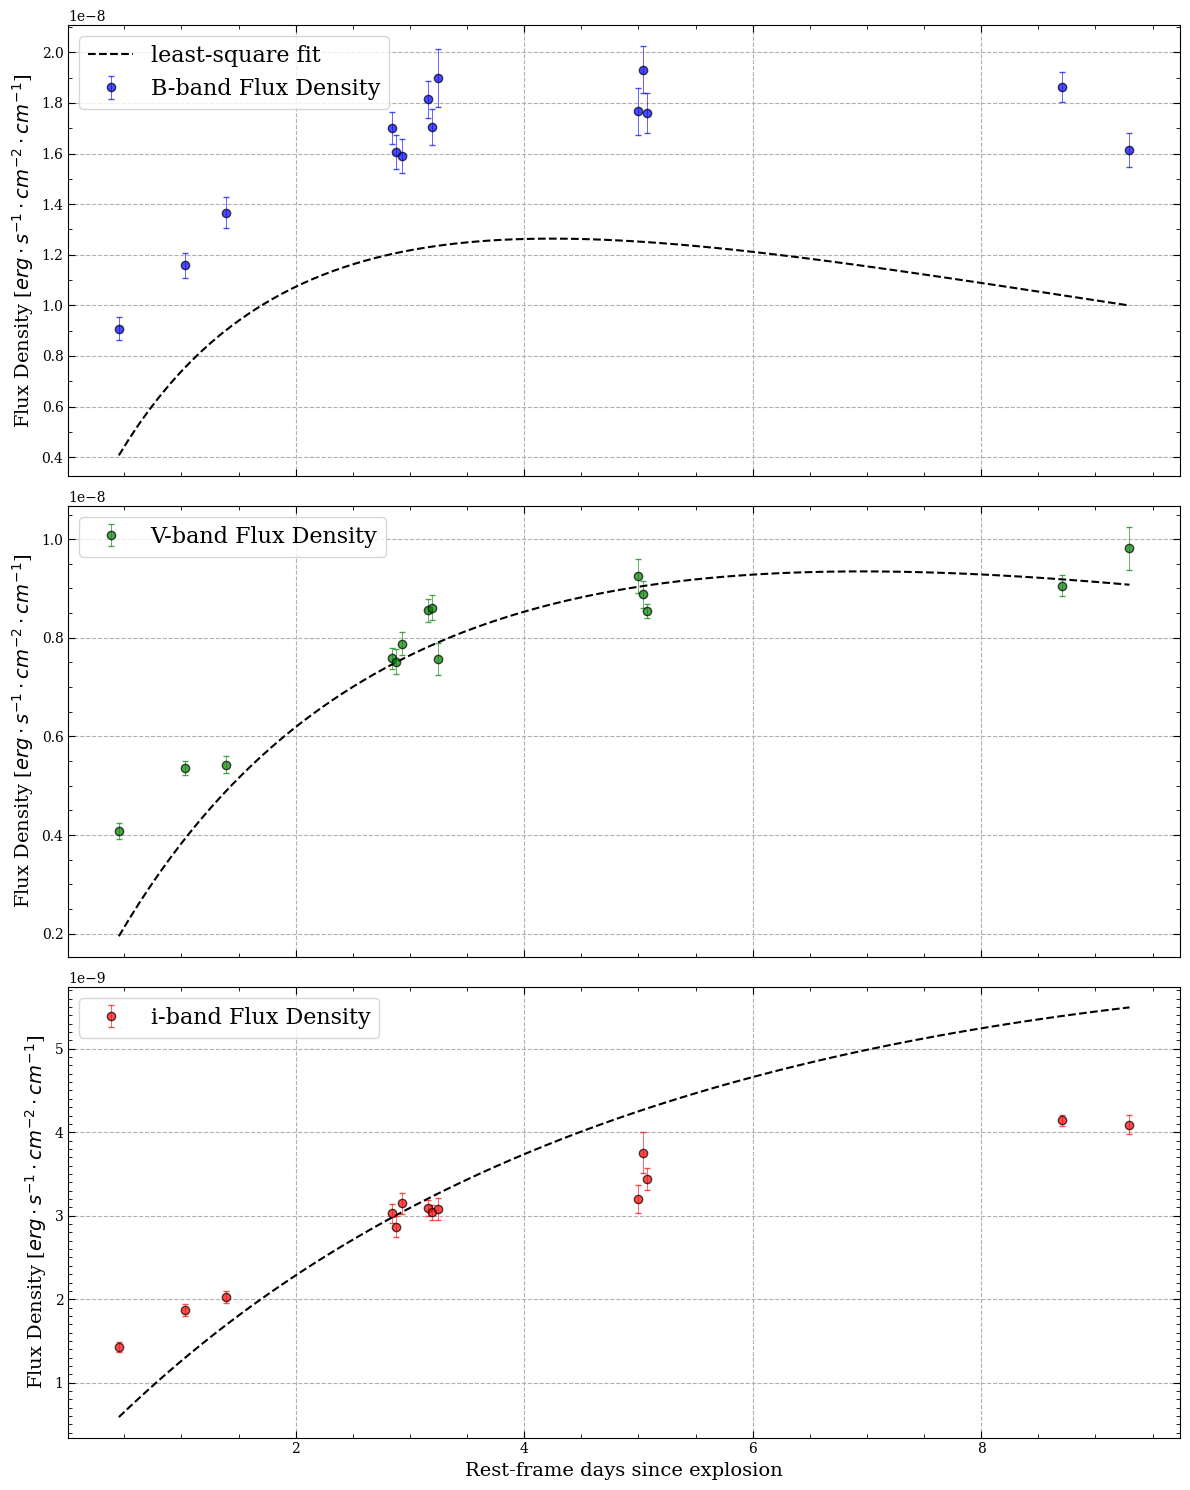

In [ ]:
domain = np.linspace(trange[0],trange[-1],100)
domain_con = np.concatenate((domain,domain,domain),axis=0)
Bpred, Vpred, ipred = ShockCoolingModel(domain_con,*poptAll)[:len(domain)],\
ShockCoolingModel(domain_con,*poptAll)[len(domain):2*len(domain)], ShockCoolingModel(domain_con,*poptAll)[2*len(domain):3*len(domain)]

fig,(a0,a1,a2) = plt.subplots(figsize=(12,15),nrows=3,sharex=True)

a0.errorbar(trange,B_slice,yerr=Berr_slice,fmt='bo',ecolor='b',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,mec='k',label='B-band Flux Density')
a0.plot(domain,Bpred,c='k',ls='--',label='least-square fit')
#a0.set_title("KSP ZN-7090 B-Band Flux Density Light Curve",fontsize=18)
a0.set_ylabel("Flux Density [$erg \cdot s^{-1}\cdot cm^{-2} \cdot cm^{-1}$]",fontsize=14)
#a0.set_xlabel("Rest-frame days since explosion",fontsize=14)
a0.legend(prop={'size':16})
a0.grid(ls='--')
a0.yaxis.set_minor_locator(MultipleLocator(0.1e-8))
a0.xaxis.set_minor_locator(MultipleLocator(0.5))
a0.yaxis.set_ticks_position('both')
a0.xaxis.set_ticks_position('both')

a1.errorbar(trange,V_slice,yerr=Verr_slice,fmt='go',ecolor='g',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,mec='k',label='V-band Flux Density')
a1.plot(domain,Vpred,c='k',ls='--')
#a1.set_title("KSP ZN-7090 V-Band Flux Density Light Curve",fontsize=18)
a1.set_ylabel("Flux Density [$erg \cdot s^{-1}\cdot cm^{-2} \cdot cm^{-1}$]",fontsize=14)
#a1.set_xlabel("Rest-frame days since explosion",fontsize=14)
a1.grid(ls='--')
a1.legend(prop={'size':16})
a1.yaxis.set_minor_locator(MultipleLocator(0.05e-8))
a1.xaxis.set_minor_locator(MultipleLocator(0.5))
a1.yaxis.set_ticks_position('both')
a1.xaxis.set_ticks_position('both')


a2.errorbar(trange,i_slice,yerr=ierr_slice,fmt='ro',ecolor='r',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,mec='k',label='i-band Flux Density')
a2.plot(domain,ipred,c='k',ls='--')
#a2.set_title("KSP ZN-7090 i-Band Flux Density Light Curve",fontsize=18)
a2.set_ylabel("Flux Density [$erg \cdot s^{-1}\cdot cm^{-2} \cdot cm^{-1}$]",fontsize=14)
a2.set_xlabel("Rest-frame days since explosion",fontsize=14)
a2.grid(ls='--')
a2.legend(prop={'size':16})
a2.yaxis.set_minor_locator(MultipleLocator(0.1e-9))
a2.xaxis.set_minor_locator(MultipleLocator(0.5))
a2.yaxis.set_ticks_position('both')
a2.xaxis.set_ticks_position('both')

plt.tight_layout()
plt.savefig("Sim Fit.jpeg")

print("Fitting Parameters")
print("Ejecta Energy:",poptAll[0],"(+/-)",np.sqrt(np.diag(pcovAll)[0]),"e51 erg")
print("Progenitor Radius:",poptAll[1],"(+/-)",np.sqrt(np.diag(pcovAll)[1]),"e13 cm")
print("Ejecta Mass:",poptAll[2],"(+/-)",np.sqrt(np.diag(pcovAll)[2]),"Msun")
print("Reduced Chi-Square")
print(red_chiAll)

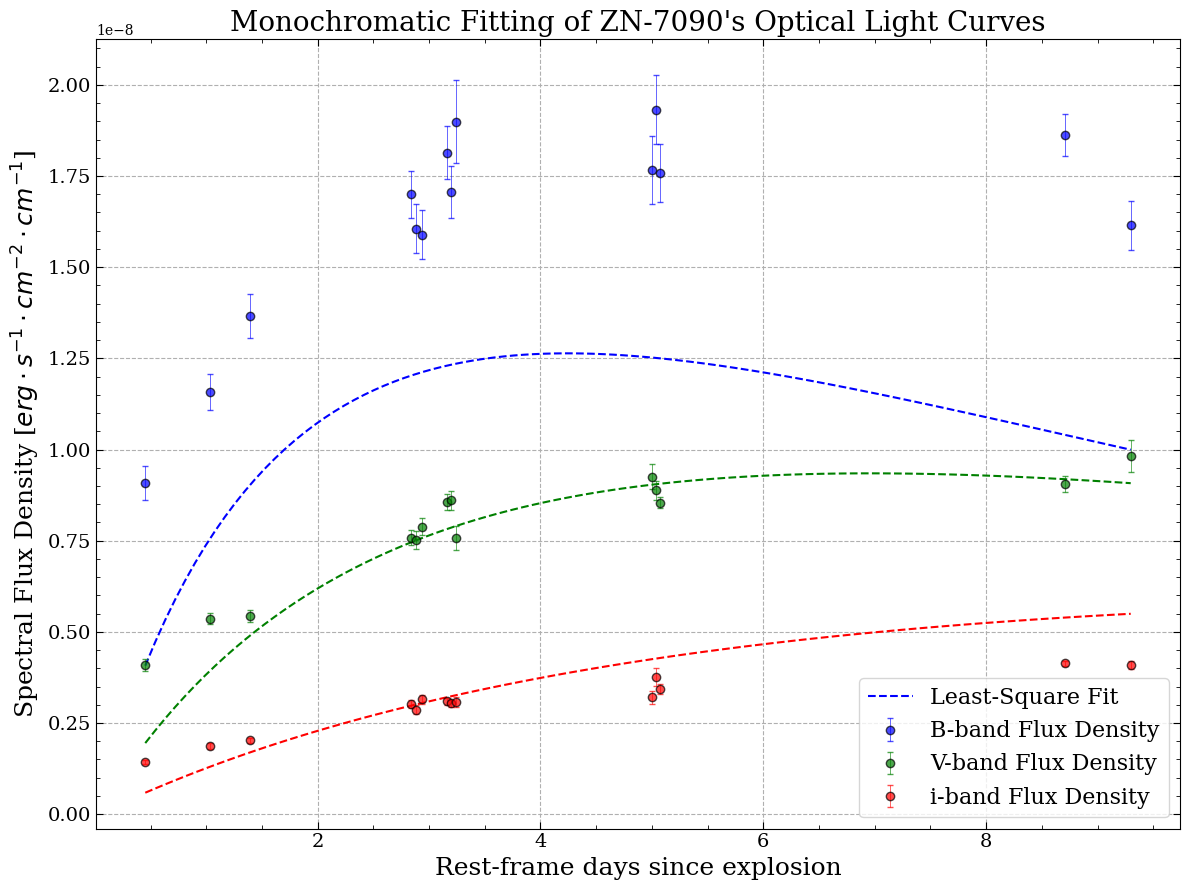

In [ ]:
fig, a0 = plt.subplots(figsize=(12,9),nrows=1)
a0.errorbar(trange,B_slice,yerr=Berr_slice,fmt='bo',ecolor='b',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,mec='k',label='B-band Flux Density')
a0.plot(domain,Bpred,c='b',ls='--',label='Least-Square Fit')
a0.errorbar(trange,V_slice,yerr=Verr_slice,fmt='go',ecolor='g',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,mec='k',label='V-band Flux Density')
a0.plot(domain,Vpred,c='g',ls='--')
a0.errorbar(trange,i_slice,yerr=ierr_slice,fmt='ro',ecolor='r',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,mec='k',label='i-band Flux Density')
a0.plot(domain,ipred,c='r',ls='--')

a0.set_title("Monochromatic Fitting of ZN-7090's Optical Light Curves",fontsize=20)
a0.set_ylabel("Spectral Flux Density [$erg \cdot s^{-1}\cdot cm^{-2} \cdot cm^{-1}$]",fontsize=18)
a0.set_xlabel("Rest-frame days since explosion",fontsize=18)
a0.legend(prop={'size':16})
a0.grid(ls='--')
a0.yaxis.set_minor_locator(MultipleLocator(0.05e-8))
a0.xaxis.set_minor_locator(MultipleLocator(0.5))
a0.yaxis.set_ticks_position('both')
a0.xaxis.set_ticks_position('both')
a0.tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.savefig("Sim_Fitting2.jpeg")

After imposing the physical bounds on ejecta mass we noticed that the chi-square did not undergo any noticeable change, this leads us to believe there exists a degeneracy in the combination of parameters that give optimal chi-squares and curve_fit is returning the smallest parameters out of this degeneracy.

Write Up:
- Confirm SED of SBO as BB
- Apply Lyman corrections to model


<h2 align='center'>Chi-Square Contour Plots for $R*$ and $M_{ej}$<h2>

In [ ]:
# Create domain for fitting parameters
R_sample = np.linspace(0.2,2,100)
M_sample = np.linspace(8,16,100)
E_sample = np.linspace(0.6,5.6,100)

# CSP Limits
#R_sample = np.linspace(0.5,2,100)
#M_sample = np.linspace(8,16,100)
#E_sample = np.linspace(0.5,5,100)


#R_sample = np.linspace(0.5,3,100)
#M_sample = np.linspace(2,6,100)
#E_sample = np.linspace(0.6,5,100)

DomainR, DomainM = np.meshgrid(R_sample,M_sample)

DomainE, DomainM2 = np.meshgrid(E_sample,M_sample)

ChiRedAll = []
for i in range(len(M_sample)):
    Mx = M_sample[i]
    row = []
    for j in range(len(R_sample)):
        Rx = R_sample[j]
        # Compute chi-square reduced with combinatin of parameters
        chix = chi_square_reduced(fwave_con,ShockCoolingModel(dates_con,poptAll[0],Rx,Mx,poptAll[3],poptAll[4]),fwave_err_con,5)
        row.append(chix)
    ChiRedAll.append(row)
    
ChiRedAllE = []
for i in range(len(M_sample)):
    Mx = M_sample[i]
    row = []
    for j in range(len(E_sample)):
        Ex = E_sample[j]
        chix = chi_square_reduced(fwave_con,ShockCoolingModel(dates_con,Ex,poptAll[1],Mx,poptAll[3],poptAll[4]),fwave_err_con,5)
        row.append(chix)
    ChiRedAllE.append(row)


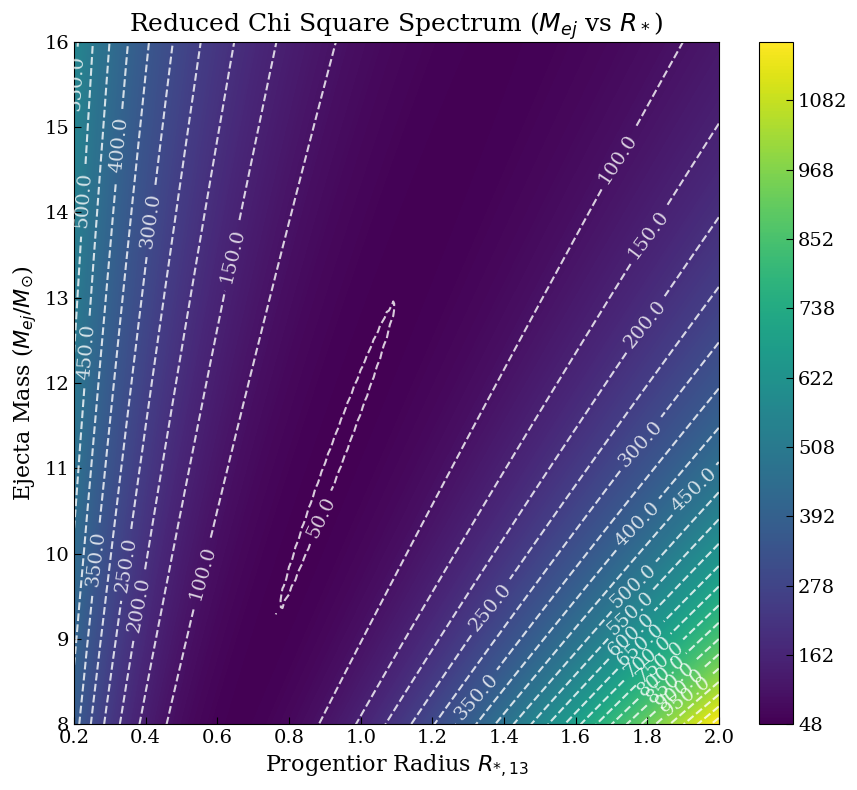

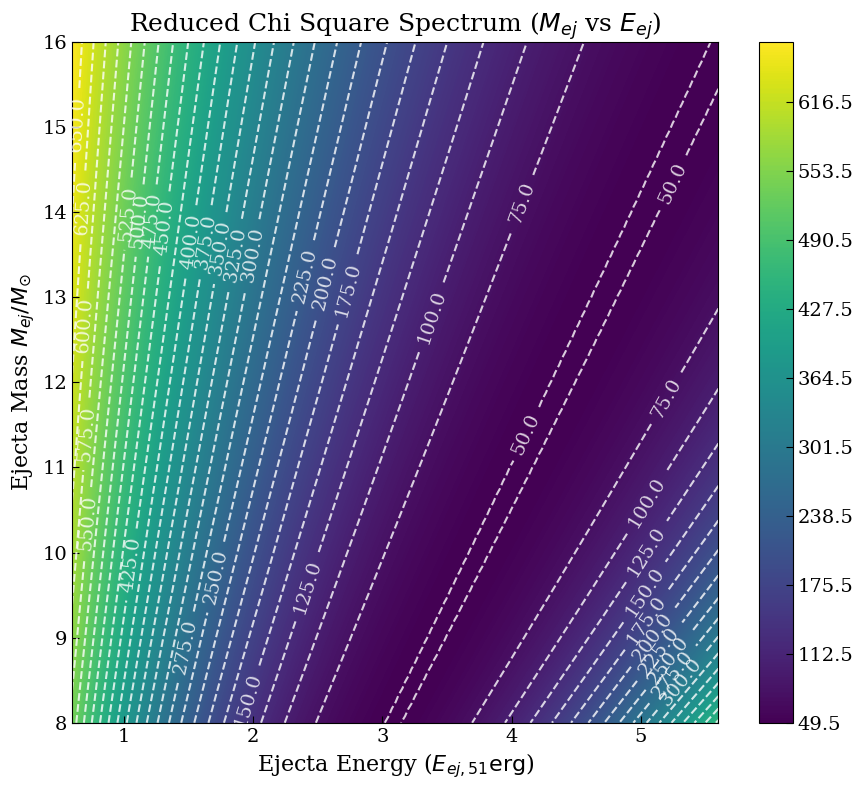

In [ ]:
fig = plt.figure(figsize=(9,8))
ax = plt.contour(DomainR,DomainM,ChiRedAll,levels=25,linestyles='dashed',colors='w',alpha=0.8)
im = plt.contourf(DomainR,DomainM,ChiRedAll,levels=500)
plt.clabel(ax, fmt='%2.1f', colors='w', fontsize=14)

plt.title(r"Reduced Chi Square Spectrum ($M_{ej}$ vs $R_*$)",fontsize=18)
plt.xlabel(r"Progentior Radius $R_{*,13}$",fontsize=16)
plt.ylabel(r"Ejecta Mass ($M_{ej}/M_{\odot}$)",fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig("Reduced Chi MvR.png")
plt.show()

fig = plt.figure(figsize=(9,8))
ax2 = plt.contour(DomainE,DomainM2,ChiRedAllE,levels=25,linestyles='dashed',colors='w',alpha=0.8)
im2 = plt.contourf(DomainE,DomainM2,ChiRedAllE,levels=500)
cbar = fig.colorbar(im2)
cbar.ax.tick_params(labelsize=14)
plt.clabel(ax2, fmt='%2.1f', colors='w', fontsize=14)
plt.title("Reduced Chi Square Spectrum ($M_{ej}$ vs $E_{ej}$)",fontsize=18)
plt.xlabel(r"Ejecta Energy ($E_{ej,51} \mathrm{erg}$)",fontsize=16)
plt.ylabel(r"Ejecta Mass $M_{ej}/M_{\odot}$",fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.tight_layout()
plt.savefig("Reduced Chi MvE.png")
plt.show()

c:\Users\patri\Desktop\SURP_Stuff\ZN7090\Scripts\Helpers.py:358: RuntimeWarning: invalid value encountered in double_scalars
  Tph = 1.6*(fp**(-0.037)*E51**0.027*R13**(1/4))/(M**0.054*k34**0.28) * t5**(-0.45)
c:\Users\patri\Desktop\SURP_Stuff\ZN7090\Scripts\Helpers.py:361: RuntimeWarning: invalid value encountered in double_scalars
  L = 8.5e42*(E51**0.92*R13)/(fp**0.27*M**0.84*k34**0.92)*t5**(-0.16)
c:\Users\patri\Desktop\SURP_Stuff\ZN7090\Scripts\Helpers.py:358: RuntimeWarning: invalid value encountered in double_scalars
  Tph = 1.6*(fp**(-0.037)*E51**0.027*R13**(1/4))/(M**0.054*k34**0.28) * t5**(-0.45)
c:\Users\patri\Desktop\SURP_Stuff\ZN7090\Scripts\Helpers.py:361: RuntimeWarning: invalid value encountered in double_scalars
  L = 8.5e42*(E51**0.92*R13)/(fp**0.27*M**0.84*k34**0.92)*t5**(-0.16)
c:\Users\patri\Desktop\SURP_Stuff\ZN7090\Scripts\Helpers.py:358: RuntimeWarning: invalid value encountered in double_scalars
  Tph = 1.6*(fp**(-0.037)*E51**0.027*R13**(1/4))/(M**0.054*k34**0.2

B - band fitting parameters
Ejecta Energy: 3.6679197534071224 e51 erg
Progenitor Radius: 0.6901425360679628 e13 cm
Ejecta Mass: 10.861789028445115 Msun
Reduced Chi-Square
6.929046828889496

V - band fitting parameters
Ejecta Energy: 3.5352145925470153 e51 erg
Progenitor Radius: 0.26891183459521584 e13 cm
Ejecta Mass: 10.821393120239414 Msun
Reduced Chi-Square
13.821698222604878

i - band fitting parameters
Ejecta Energy: 3.4556052712568404 e51 erg
Progenitor Radius: 0.08607367165457203 e13 cm
Ejecta Mass: 10.828623499945282 Msun
Reduced Chi-Square
12.13634549238459



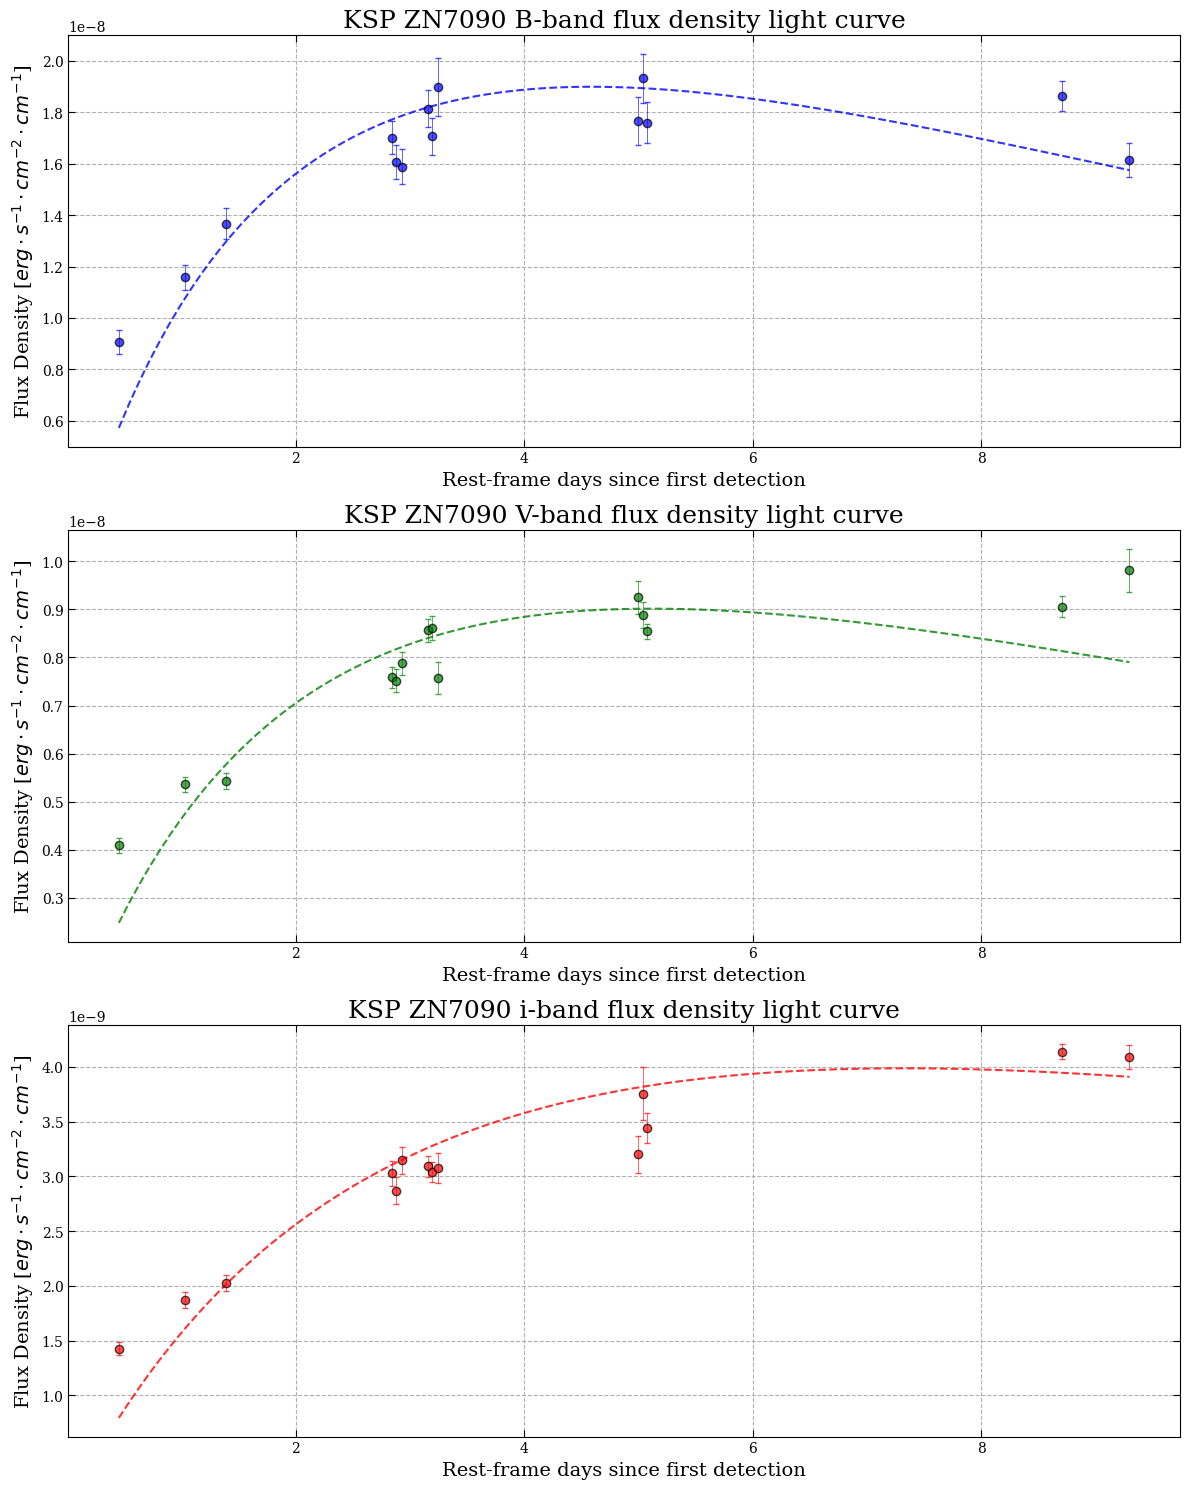

In [ ]:
# Store Wavelengths [B,V,i]
wavelengths = np.array([0.4361,0.5448,0.7672])*1e-4 #um -> cm

# Stack arrays to access them via for-loop
dates_con2 = np.vstack((trange,trange,trange))
fwave_con2 = np.vstack((B_slice,V_slice,i_slice))
fwave_err_con2 = np.vstack((Berr_slice,Verr_slice,ierr_slice))

# Style feature for plotting 
form = ['bo','go','ro']
colors = ['b','g','r']
names = ['B','V','i']

fig = plt.figure(figsize=(12,15))

for i,wave in enumerate(wavelengths):
    # Define function for specific wavelength
    def single_model(t_day,E51,R13,M,k34,fp):
        # Constants
        c = 2.99792458e10 #cm/s
        kB = 8.617333262e-5 #eV/K

        # Scale time
        t = t_day * 86400 #s
        t5 = t/1e5

        # Use analytical models to compute L and T
        L,Tph = RabinakShockCooling(t5,E51,R13,M,k34,fp)

        # Convert Tph eV -> K
        Tph = Tph/kB

        z = 0.1

        dl = 435.0*1e6 # Mpc -> pc

        # Compute theoretical flux density given T and L
        Fnu = np.array(BBflux(L,Tph,wave,z,dl)) # erg/s/cm2/Hz

        # Convert to units of erg/s/cm2/cm
        Fwave = (c/wave**2)*Fnu

        return(Fwave)

    popt, pcov = curve_fit(single_model,trange,fwave_con2[i],sigma=fwave_err_con2[i],absolute_sigma=True,\
                          bounds=([-np.inf,-np.inf,8,-np.inf,-np.inf],[np.inf,np.inf,16,np.inf,np.inf]))
    ax = plt.subplot(3,1,i+1)
    
    ax.errorbar(trange,fwave_con2[i],yerr=fwave_err_con2[i],fmt=form[i],ecolor=colors[i],capsize=2,elinewidth=0.6,alpha=0.7,ms=6,mec='k')
    ax.plot(domain,single_model(domain,*popt),c=colors[i],alpha=0.8,ls='--')
    ax.set_ylabel("Flux Density [$erg \cdot s^{-1}\cdot cm^{-2} \cdot cm^{-1}$]",fontsize=14)
    ax.set_xlabel("Rest-frame days since first detection",fontsize=14)
    ax.set_title(f"KSP ZN7090 {names[i]}-band flux density light curve",fontsize=18)
    ax.grid(ls='--')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    print(names[i],"- band fitting parameters")
    print("Ejecta Energy:",popt[0],"e51 erg")
    print("Progenitor Radius:",popt[1],"e13 cm")
    print("Ejecta Mass:",popt[2],"Msun")
    
    red_chix = chi_square_reduced(fwave_con2[i],single_model(trange,*popt),fwave_err_con2[i],5)
    print("Reduced Chi-Square")
    print(red_chix)
    print()
    
plt.tight_layout()
plt.savefig("Ind Fit.png")

By noting the poor quality of the simultaneous fit we will proceed to perform a simultaneous fit only on the B and V band because of a gut feeling

In [ ]:
def TwoBandModelVi(t_day,E51,R13,M,k34,fp):
    """
    Model function for flux density per unit wavelenght given
    analytical Temp and L from Rabinak & Waxman.
    """
    # Constants
    c = 2.99792458e10 #cm/s
    kB = 8.617333262e-5 #eV/K
    
    # Scale time
    t = t_day * 86400 #s
    t5 = t/1e5
    
    
    # Use analytical models to compute L and T
    L,Tph = RabinakShockCooling(t5,E51,R13,M,k34,fp)
    
    # Convert Tph eV -> K
    Tph = Tph/kB
    
    #Bwave = 0.4361*1e-4 # convert um -> cm (B-band)
    Vwave = 0.5448*1e-4 # convert um -> cm (V-band)
    iwave = 0.7672*1e-4 # convert um -> cm (i-band)
    
    z = 0.1
    
    dl = 435.0*1e6 # Mpc -> pc
    
    # Compute theoretical flux density given T and L
    #FnuB = np.array(BBflux(L,Tph,Bwave,z,dl)) # erg/s/cm2/Hz
    FnuV = np.array(BBflux(L,Tph,Vwave,z,dl)) # erg/s/cm2/Hz
    Fnui = np.array(BBflux(L,Tph,iwave,z,dl)) # erg/s/cm2/Hz
    
    # Convert to units of erg/s/cm2/cm
    #FwaveB = (c/Bwave**2)*FnuB
    FwaveV = (c/Vwave**2)*FnuV
    Fwavei = (c/iwave**2)*Fnui
    
    return(np.concatenate((FwaveV,Fwavei),axis=0))

def TwoBandModelBV(t_day,E51,R13,M,k34,fp):
    """
    Model function for flux density per unit wavelenght given
    analytical Temp and L from Rabinak & Waxman.
    """
    # Constants
    c = 2.99792458e10 #cm/s
    kB = 8.617333262e-5 #eV/K
    
    # Scale time
    t = t_day * 86400 #s
    t5 = t/1e5
    
    
    # Use analytical models to compute L and T
    L,Tph = RabinakShockCooling(t5,E51,R13,M,k34,fp)
    
    # Convert Tph eV -> K
    Tph = Tph/kB
    
    Bwave = 0.4361*1e-4 # convert um -> cm (B-band)
    Vwave = 0.5448*1e-4 # convert um -> cm (V-band)
    #iwave = 0.7672*1e-4 # convert um -> cm (i-band)
    
    z = 0.1
    
    dl = 435.0*1e6 # Mpc -> pc
    
    # Compute theoretical flux density given T and L
    FnuB = np.array(BBflux(L,Tph,Bwave,z,dl)) # erg/s/cm2/Hz
    FnuV = np.array(BBflux(L,Tph,Vwave,z,dl)) # erg/s/cm2/Hz
    #Fnui = np.array(BBflux(L,Tph,iwave,z,dl)) # erg/s/cm2/Hz
    
    # Convert to units of erg/s/cm2/cm
    FwaveB = (c/Bwave**2)*FnuB
    FwaveV = (c/Vwave**2)*FnuV
    #Fwavei = (c/iwave**2)*Fnui
    
    return(np.concatenate((FwaveB,FwaveV),axis=0))

def TwoBandModelBi(t_day,E51,R13,M,k34,fp):
    """
    Model function for flux density per unit wavelenght given
    analytical Temp and L from Rabinak & Waxman.
    """
    # Constants
    c = 2.99792458e10 #cm/s
    kB = 8.617333262e-5 #eV/K
    
    # Scale time
    t = t_day * 86400 #s
    t5 = t/1e5
    
    
    # Use analytical models to compute L and T
    L,Tph = RabinakShockCooling(t5,E51,R13,M,k34,fp)
    
    # Convert Tph eV -> K
    Tph = Tph/kB
    
    Bwave = 0.4361*1e-4 # convert um -> cm (B-band)
    #Vwave = 0.5448*1e-4 # convert um -> cm (V-band)
    iwave = 0.7672*1e-4 # convert um -> cm (i-band)
    
    z = 0.1
    
    dl = 435.0*1e6 # Mpc -> pc
    
    # Compute theoretical flux density given T and L
    FnuB = np.array(BBflux(L,Tph,Bwave,z,dl)) # erg/s/cm2/Hz
    #FnuV = np.array(BBflux(L,Tph,Vwave,z,dl)) # erg/s/cm2/Hz
    Fnui = np.array(BBflux(L,Tph,iwave,z,dl)) # erg/s/cm2/Hz
    
    # Convert to units of erg/s/cm2/cm
    FwaveB = (c/Bwave**2)*FnuB
    #FwaveV = (c/Vwave**2)*FnuV
    Fwavei = (c/iwave**2)*Fnui
    
    return(np.concatenate((FwaveB,Fwavei),axis=0))

In [ ]:
# Concatenate 2 Band data (B,V)
TwoDataVi = np.concatenate((V_slice,i_slice),axis=0)
TwoErrVi = np.concatenate((Verr_slice,ierr_slice),axis=0)
TwoDates = np.concatenate((trange,trange),axis=0)

TwoDataBV = np.concatenate((B_slice,V_slice),axis=0)
TwoErrBV = np.concatenate((Berr_slice,Verr_slice),axis=0)

TwoDataBi = np.concatenate((B_slice,i_slice),axis=0)
TwoErrBi = np.concatenate((Berr_slice,ierr_slice),axis=0)

In [ ]:
poptVi, pcovVi = curve_fit(TwoBandModelVi,trange,TwoDataVi,sigma=TwoErrVi,\
                        bounds=([-np.inf,-np.inf,8,-np.inf,-np.inf],[np.inf,np.inf,16,np.inf,np.inf]))
chi_redVi = chi_square_reduced(TwoDataVi,TwoBandModelVi(trange,*poptVi),TwoErrVi,5)


poptBV, pcovBV = curve_fit(TwoBandModelBV,trange,TwoDataBV,sigma=TwoErrBV,\
                        bounds=([-np.inf,-np.inf,8,-np.inf,-np.inf],[np.inf,np.inf,16,np.inf,np.inf]))
chi_redBV = chi_square_reduced(TwoDataBV,TwoBandModelBV(trange,*poptBV),TwoErrBV,5)

poptBi, pcovBi = curve_fit(TwoBandModelBi,trange,TwoDataBi,sigma=TwoErrBi,\
                        bounds=([-np.inf,-np.inf,8,-np.inf,-np.inf],[np.inf,np.inf,16,np.inf,np.inf]))
chi_redBi = chi_square_reduced(TwoDataBi,TwoBandModelBi(trange,*poptBi),TwoErrBi,5)


print("Fitting Parameters (V&i)")
print("Ejecta Energy:",poptVi[0],"e51 erg")
print("Progenitor Radius:",poptVi[1],"e13 cm")
print("Ejecta Mass:",poptVi[2],"Msun")
print("Reduced Chi-Square",chi_redVi)
print()
print("Fitting Parameters (B&i)")
print("Ejecta Energy:",poptBi[0],"e51 erg")
print("Progenitor Radius:",poptBi[1],"e13 cm")
print("Ejecta Mass:",poptBi[2],"Msun")
print("Reduced Chi-Square",chi_redBi)
print()
print("Fitting Parameters (B&V)")
print("Ejecta Energy:",poptBV[0],"e51 erg")
print("Progenitor Radius:",poptBV[1],"e13 cm")
print("Ejecta Mass:",poptBV[2],"Msun")
print("Reduced Chi-Square",chi_redBV)

Fitting Parameters (V&i)
Ejecta Energy: 3.6060613034650455 e51 erg
Progenitor Radius: 0.3011704235742064 e13 cm
Ejecta Mass: 10.733446333577927 Msun
Reduced Chi-Square 31.920861077167192

Fitting Parameters (B&i)
Ejecta Energy: 3.7602289492069265 e51 erg
Progenitor Radius: 1.489019380395627 e13 cm
Ejecta Mass: 11.0812244126529 Msun
Reduced Chi-Square 60.48766731273981

Fitting Parameters (B&V)
Ejecta Energy: 3.916081614061991 e51 erg
Progenitor Radius: 0.7931921398500907 e13 cm
Ejecta Mass: 10.896590333156794 Msun
Reduced Chi-Square 34.93689873004797


c:\Users\patri\Desktop\SURP_Stuff\ZN7090\Scripts\Helpers.py:358: RuntimeWarning: invalid value encountered in double_scalars
  Tph = 1.6*(fp**(-0.037)*E51**0.027*R13**(1/4))/(M**0.054*k34**0.28) * t5**(-0.45)
c:\Users\patri\Desktop\SURP_Stuff\ZN7090\Scripts\Helpers.py:361: RuntimeWarning: invalid value encountered in double_scalars
  L = 8.5e42*(E51**0.92*R13)/(fp**0.27*M**0.84*k34**0.92)*t5**(-0.16)


In [ ]:
Vpred2, ipred2 = TwoBandModel(domain,*popt2)[:len(domain)], TwoBandModel(domain,*popt2)[len(domain):2*len(domain)]

fig,a0 = plt.subplots(figsize=(11,7),ncols=1)

a0.plot(domain,Vpred2,c='g',ls='--',alpha=0.6)
a0.errorbar(trange,V_slice,yerr=Verr_slice,fmt='go',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,mec='k')
a0.plot(domain,ipred2,c='r',ls='--',alpha=0.6)
a0.errorbar(trange,i_slice,yerr=Verr_slice,fmt='ro',capsize=2,elinewidth=0.6,alpha=0.7,ms=6,mec='k')
a0.set_xlabel("Rest-frame days since explosion",fontsize=16)
a0.set_ylabel(r"Spectral Flux Density [$erg\cdot s^{-1}\cdot cm^{-2} \cdot cm^{-1}$]",fontsize=16)
a0.set_title("Dual Band Fitting (V & i)",fontsize=18)
a0.grid(ls='--')
plt.tight_layout()
plt.show()

NameError: name 'TwoBandModel' is not defined

In [4]:
import sympy as sy

A = sy.Matrix([[5/2, 0],[-3/2 ,1]])
A.inv()

Matrix([
[0.4,   0],
[0.6, 1.0]])